In [3]:
import pandas as pd
import numpy 
import os
import git
import pickle
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', -1)
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
import warnings
warnings.filterwarnings('ignore')
from matplotlib import pyplot
import numpy as np
import re
from collections import Counter
# import gensim
# from gensim import corpora
import os
import networkx as nx
import ast

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.utils import shuffle

In [5]:
from keras.preprocessing.sequence import pad_sequences
from keras.optimizers import SGD
from keras.models import Model, Input
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Reshape
from keras.layers import Average
from keras.layers import Dropout
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from tqdm import tqdm as tqdm

In [7]:
## Read the labelled files and the poly_user
def get_git_root(path):
	git_repo = git.Repo(path, search_parent_directories=True)
	git_root = git_repo.git.rev_parse("--show-toplevel")
	return git_root

In [8]:
from nltk.corpus import wordnet as wn
def get_lemma(word):
    lemma = wn.morphy(word)
    if lemma is None:
        return word
    else:
        return lemma

In [9]:
# setup env
import nltk
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('stopwords')
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to
[nltk_data]     /home/drew_william2345/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/drew_william2345/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
## tokenize the text..
from keras.preprocessing.text import Tokenizer
from keras.layers import Embedding
from nltk.tokenize import TweetTokenizer
tweet_tknzr = TweetTokenizer()
def get_tokens(sentence):
#     tokens = nltk.word_tokenize(sentence)  # now using tweet tokenizer
    tokens = tweet_tknzr.tokenize(sentence)
    tokens = [token for token in tokens if (token not in stopwords and len(token) > 1)]
    tokens = [get_lemma(token) for token in tokens]
    return (tokens)

In [89]:
def clean_text(text):
    text = re.sub(r'(https?://\S+)', "", text) ## remove url
    text = re.sub(r'(\@\w+)', "author",text)   ## remove @ mentions with author
    text = re.sub(r'(@)', "",text)             ## remove @ symbols
    text = re.sub(r'(author)',"",text)         ## remove author
    text = re.sub(r'(#)', "",text)             ## removing the hashtags signal 
    text = re.sub(r'(RT )', "",text)         ## remove the retweet info as they dont convey any information
    text.rstrip 
    text.lstrip
    return(text)

In [12]:
# create the word2vec dict from the dictionary
def get_word2vec(file_path):
    file = open(file_path, "r")
    if (file):
        word2vec = dict()
#         split = file.read().splitlines()
        for line in file:
            split_line = line.split(' ')
            key = split_line[0] # the first word is the key
            value = np.array([float(val) for val in split_line[1:]])
            word2vec[key] = value
        return (word2vec)
    else:
        print("invalid fiel path")

In [13]:
## calculate the mean of the embeddings
class MeanEmbeddingVectorizer(object):
	def __init__(self, word2vec):
		self.word2vec = word2vec
		# if a text is empty we should return a vector of zeros
		# with the same dimensionality as all the other vectors
		self.dim = len(next(iter(word2vec.values())))

	def fit(self, X, y):
		return self

	def transform(self, X):
		return np.array([
			np.mean([self.word2vec[w] for w in words if w in self.word2vec]
					or [np.zeros(self.dim)], axis=0)
			for words in tqdm(X)
		])

In [14]:
top_dir = os.path.join(get_git_root(os.getcwd()))
input_dir = os.path.join(get_git_root(os.getcwd()),"input")
embeddings_dir  = os.path.join(get_git_root(os.getcwd()),"input","embeddings")
annotatted_dir = os.path.join(input_dir,"annotated_data")
classifier_dir = os.path.join(get_git_root(os.getcwd()),"models","classifier")
model_dir = os.path.join(get_git_root(os.getcwd()),"models")
poly_dir = os.path.join(model_dir,"poly_users")

In [15]:
glove_embeddings = os.path.join(embeddings_dir,"glove.twitter.27B.100d.txt")

In [16]:
df_following_final = pd.read_csv(os.path.join(input_dir,"following_final.csv"))

In [142]:
df_hexagon = pd.read_csv(os.path.join(input_dir,"hexagonData.csv"),lineterminator="\n")

In [145]:
len(df_hexagon.userID.unique())

7371

### getting the input consolidated data (combing timeline and hexagon data)

In [38]:
df_tweets = pd.read_csv(os.path.join(input_dir,"extraction","consolidated_data.csv"), lineterminator="\n")

In [39]:
len(df_tweets)

123163

### annotation data

In [400]:
df_annotation =pd.read_excel(os.path.join(annotatted_dir,"annotated_new.xlsx"),index_col=0) ## changed annotation file

In [401]:
len(df_tweets.userID.unique())

5520

In [402]:
len(df_annotation)

876

In [403]:
## 0 -news
## 1 - promo
## 2 -regular users
print(df_annotation.label.value_counts())
df_annotation = df_annotation.sample(frac=1)
df_annotation = df_annotation.reset_index()

0    408
2    246
1    222
Name: label, dtype: int64


In [404]:
## take a balnced sample of 200 from each category
df_news = (df_annotation[df_annotation.label == 0])[:200] 
df_reg = (df_annotation[df_annotation.label == 2])[:200] 
df_promo = (df_annotation[df_annotation.label == 1])[:200] 
df_annotation = pd.concat([df_news,df_promo,df_reg])

In [406]:
## random sample annotation file
df_annotation = df_annotation.sample(frac=1).reset_index(drop=True)

In [408]:
## tokenize the sentences
df_annotation['tweetText'] = df_annotation['tweetText'].apply(clean_text)

In [411]:
df_annotation.loc[df_annotation.label.isin([1,2])].head(200)

,tweetText,label
0,"I'm multitasking: I can listen, ignore and forget at the same time. stoned whatstonedpeoplesay Cannabis marijuana iamstoned",2
1,UBLO HEMP CBD Vape Juice | E Liquid | eliquid 0% Nicotine 6 STRENGTH 6 Flavours Hemp Oil ON E BAY … … … … vapecommunity vapefamily vapeshop Vape cloudchaser vapelife vapeporn CBD JBRT18VAPE ublo CBDlife atsocialmedia tweetmaster hemp,1
2,"Well done . Literally smoke &amp; mirrors, this is pretty much all tobacco money.",2
3,Luxury wellness embraces cannabis luxury cannabis business opportunity business innovation development health lifestyle Goop CPPLuxury,1
4,Note to &amp; re healthoutcomes: healthcare access is a socialdeterminant of health just like food nutrition cleanwater cleanair education tobacco - Medicaid cover is necessary but not sufficient for whole health,2
6,"Dr. Gottlieb, wouldn't the troubling reality be if combustible cigarettes were the most commonly used tobacco product? Can one ask this question while still believing youth should never use any nicotine product, including e-cigarettes, which incorrectly calls tobacco ?",2
7,PUFF PUFF PASS! joints blunts smokedout jointart cannabis weed hightimes puffpuffpass smokeshop stoned,2
10,No time for haters trap rap hiphop trampa trvp VAPORWAVE vape aesthetic lofi lofihiphop SoundCloud trvp venezuela latintrap traplatino reggaeton homestudio smoke…,1
12,"Which would I rather my child use ""Alcohol or Marijuana? A Pediatrician Faces the Question"" pot winning. drugs",2
14,Come On CANADA!! Get your shit together!! LegalizeIt Recreational Marijuana,2


In [396]:
## looking at the tokenized data
df_test = pd.DataFrame()
df_test["tweetText"] = list(df_annotation['tweetText'].apply(get_tokens))
df_test['label'] = list(df_annotation["label"])
df_test

,tweetText,label
0,"[Ecig, chemical, exposure, nonsmoker, tobacco, smoking]",0
1,"[Wow, The, pasty, real, weed, pot, cannabis, high, stone]",2
2,"[Open, Daily, 9-9, Berkeley, CA, smokeshop, glassgallery, glasscollector, glasspipe, glassart, kush, weed, cannabis]",1
3,"[Just, Listed, Soccer, Snoopy, Sugar, Skull, Padded, Pipe, Pouches, Find, style, stayhigh, stoner, weed, marijuana, cannabis, smoking, pothead, puffpuffpass, handmade, stone, dab, shopping]",1
4,"[reckon, might, law, suit, two, Ignoring, hiding, advice, danger, product, happen, Tobacco, asbestos, climatechange]",2
5,"[Legalize, Yah's, Therapeutic, FoodGrade, Medical, Cannabinoid, Terpene, CBD, Rich, CannabisSativaL, Aka, Hemp, KanehBosm, KanehBos, CannabisRuderalis, Medicinal, CannabisSativa, Hybrid, Combo, instead, evil, Twin, CannabisIndica]",1
6,"[Toxic, chemical, cigarette, remain, toxic, secondhand, smoke, ETS]",0
7,"[If, good, enough, multi-milllionaire, good, enough, LegalizeIt, Marijuana, Pot]",1
8,"[ecigs, help, many, smoker, switch, tobacco, Why, risk, hard, work, battle, quit, BBCvapemeet]",0
9,"[You, deserve, silicone, trust, Eyce, answer, Checkout, unique, The, feature, Platinum, Cured, Silicone, pipe, accessory, unique, function, unlike, anything, try, smoke, cannabis, pipe, durable, unique, smokeshop]",1


,0
count,600.000000
mean,14.031667
std,7.027539
min,2.000000
25%,9.000000
50%,12.000000
75%,17.000000
max,42.000000


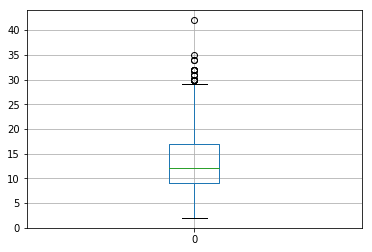

In [158]:
## getting mean , quantile length of text
df_len = list()
for tokens in token_list:
    df_len.append(len(tokens))
df_len = pd.DataFrame(df_len)
df_len.boxplot()
df_len.describe()

In [159]:
max_len = int(df_len.quantile(0.95))  ## take the max_len = 90 percentile
max_len

28

### fitting keras tokenizer on annotation data

In [ ]:
# preparign the keras tokenizer -- fitting on annnotation data
from keras.preprocessing.text import Tokenizer
keras_tkzr = Tokenizer()
keras_tkzr.fit_on_texts(df_annotation["tweetText"])
vocab_size = len(keras_tkzr.word_index) + 1
vocab_size

In [130]:
## DONT RUN AGAIN!!
word2vec = get_word2vec(os.path.join(embeddings_dir,glove_embeddings))

## predicting promoter, regular, news from data using bilstm model

In [127]:
## get the embedding matrix weights:
from numpy import zeros
from keras.preprocessing.text import Tokenizer
def get_embedding_matrix(keras_tkzr,word2vec):
    vocab_size = len(keras_tkzr.word_index) + 1
    embedding_matrix = zeros((vocab_size, 100))
    for word, i in keras_tkzr.word_index.items():
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return (embedding_matrix,vocab_size)

In [133]:
## pass to the bi-lstm model
def create_model(max_len,vocab_size,embedding_matrix):
    input = Input(shape=(max_len,))
    model = Embedding(vocab_size,100,weights=[embedding_matrix],input_length=max_len)(input)
    model =  Bidirectional (LSTM (100,return_sequences=True,dropout=0.50),merge_mode='concat')(model)
    model = TimeDistributed(Dense(100,activation='relu'))(model)
    model = Flatten()(model)
    model = Dense(100,activation='relu')(model)
    output = Dense(3,activation='softmax')(model)
    model = Model(input,output)
    model.compile(loss='sparse_categorical_crossentropy',optimizer='adam', metrics=['accuracy'])
    return model

In [124]:
from keras.preprocessing.text import Tokenizer
def load_data(df,max_len):
    keras_tkzr = Tokenizer()
    le = LabelEncoder()
    keras_tkzr.fit_on_texts(df["tweetText"])
    ## getting input X
    token_list = list(df['tweetText'].apply(get_tokens))
    encoded_docs = keras_tkzr.texts_to_sequences(token_list)
    max_len = max_len
    X = pad_sequences(encoded_docs, maxlen=max_len, padding='post')
    ## getting output Y
    Y = (list(df['label']))
    le.fit(Y)
    le.classes_
    y = le.transform(Y)
    return (X,y,keras_tkzr)

In [172]:
## get the trained model
def train_evaluate_model(model,X_train,Y_train,X_test,Y_test):
    loss, accuracy = model.evaluate(X_test, Y_test, verbose=2)
    print('Accuracy: %f' % (accuracy*100))
    Y_pred = model.predict(X_test)
    y_pred = np.array([np.argmax(pred) for pred in Y_pred])
    # scores = cross_val_score(model, X_test, Y_test, cv=5)
    print('  Classification Report:\n',classification_report(Y_test,y_pred),'\n')
    precision,recall,fscore,_ = precision_recall_fscore_support(Y_test,y_pred)
    return (model,precision,recall,fscore)

In [135]:
def fit_model(model,X_train,Y_train,epoch):
    hist = model.fit(X_train,Y_train,validation_split=0.25, nb_epoch = epoch, verbose = 2)
    return model,hist

In [347]:
n_folds = 3

X, y, keras_tkzr = load_data(df_annotation,max_len)
embedding_matrix, vocab_size = get_embedding_matrix(keras_tkzr,word2vec)
skf = StratifiedKFold(n_splits=n_folds, shuffle=True)
scores = []
for i ,(train, test) in enumerate(skf.split(X,y)):
    print ("Running Fold", i+ 1, "/", n_folds)
    model = None # Clearing the NN.
    model = create_model(max_len,vocab_size,embedding_matrix)
    model,_ = fit_model(model, X[train], y[train],5)
    model,precision,recall,fscore = train_evaluate_model(model, X[train], y[train], X[test], y[test])
    scores.append([precision,recall,fscore])   

Running Fold 1 / 3
Train on 299 samples, validate on 100 samples
Epoch 1/5
 - 22s - loss: 1.1307 - acc: 0.3545 - val_loss: 1.0653 - val_acc: 0.4500
Epoch 2/5
 - 2s - loss: 1.0077 - acc: 0.5418 - val_loss: 1.0123 - val_acc: 0.5400
Epoch 3/5
 - 2s - loss: 0.9077 - acc: 0.6154 - val_loss: 0.9789 - val_acc: 0.5200
Epoch 4/5
 - 2s - loss: 0.7791 - acc: 0.6890 - val_loss: 0.9960 - val_acc: 0.5700
Epoch 5/5
 - 2s - loss: 0.6923 - acc: 0.7157 - val_loss: 0.9766 - val_acc: 0.6200
Accuracy: 65.174129
  Classification Report:
              precision    recall  f1-score   support

          0       0.72      0.61      0.66        67
          1       0.74      0.55      0.63        67
          2       0.56      0.79      0.66        67

avg / total       0.67      0.65      0.65       201
 

Running Fold 2 / 3
Train on 299 samples, validate on 100 samples
Epoch 1/5
 - 23s - loss: 1.1130 - acc: 0.3478 - val_loss: 1.0849 - val_acc: 0.4700
Epoch 2/5
 - 2s - loss: 1.0030 - acc: 0.5418 - val_loss: 0.9

              0
count  3.000000
mean   0.588011
std    0.060045
min    0.552846
25%    0.553346
50%    0.553846
75%    0.605594
max    0.657343


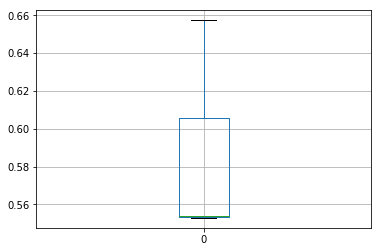

In [349]:
# max_len = 27 ## bi-lstm 
f1_score = pd.DataFrame(fscore)
print(f1_score.describe())
f1_score.boxplot()

In [452]:
## 
max_len = max_len
X, y,keras_tkzr  = load_data(df_annotation,max_len)
embedding_matrix, vocab_size = get_embedding_matrix(keras_tkzr,word2vec)
X_train,X_test, Y_train, Y_test = train_test_split(X,y,test_size=0.25,random_state =4)
model = create_model(max_len,vocab_size,embedding_matrix)
model,hist = fit_model(model, X_train, Y_train,5)
_, accuracy = model.evaluate(X_test, Y_test, verbose=2)
print('Accuracy: %f' % (accuracy*100))
Y_pred = model.predict(X_test)
y_pred = np.array([np.argmax(pred) for pred in Y_pred])
print('  Classification Report:\n',classification_report(Y_test,y_pred),'\n')

Train on 337 samples, validate on 113 samples
Epoch 1/5
 - 28s - loss: 1.0656 - acc: 0.4214 - val_loss: 0.9714 - val_acc: 0.5487
Epoch 2/5
 - 2s - loss: 0.9040 - acc: 0.6053 - val_loss: 0.8638 - val_acc: 0.6637
Epoch 3/5
 - 2s - loss: 0.7945 - acc: 0.6499 - val_loss: 1.1330 - val_acc: 0.5310
Epoch 4/5
 - 2s - loss: 0.7912 - acc: 0.6677 - val_loss: 0.8412 - val_acc: 0.6372
Epoch 5/5
 - 2s - loss: 0.6487 - acc: 0.7418 - val_loss: 0.8888 - val_acc: 0.6195
Accuracy: 65.333333
  Classification Report:
              precision    recall  f1-score   support

          0       0.73      0.69      0.71        51
          1       0.56      0.63      0.59        51
          2       0.69      0.65      0.67        48

avg / total       0.66      0.65      0.66       150
 



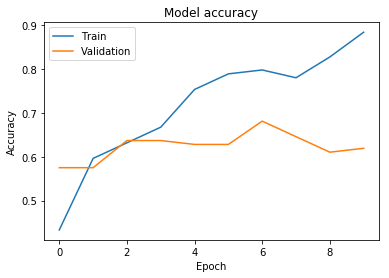

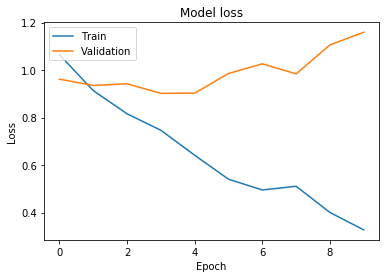

In [450]:
# Plot training & validation accuracy values
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

### getting baselines of tf-idf using SVM etc

In [412]:
def load_data_tfidf(df):
    tf_idf = TfidfVectorizer(sublinear_tf=True)
    tf_idf.fit(df["tweetText"])
    feature_names = np.array(tf_idf.get_feature_names())
    print(len(feature_names))
    X = tf_idf.fit_transform(df["tweetText"])
    Y = (list(df['label']))
    le = LabelEncoder()
    le.fit(Y)
    print(le.classes_)
    y = le.transform(Y)
    print("X.shape:",X.shape)
    return (X,y,tf_idf)

In [413]:
def svm_wrapper(X_train,Y_train):
    param_grid = [
    {'C': [1, 10], 'kernel': ['linear']},
    {'C': [1, 10], 'gamma': [0.1,0.01], 'kernel': ['rbf']},]
    svm1 = GridSearchCV(SVC(),param_grid)
    svm1.fit(X_train, Y_train)
    return(svm1)

In [433]:
df_annotation.head(30)

,tweetText,label
0,24 things you never knew about marijuana,0
1,Millions of Americans to vote on marijuana legalization via LegalizeIt Pot Cannabis Weed,0
2,The White House allegedly has a secret anti-weed committee via weedstagram weed drugs,0
3,Throwback when I discovered 😂🤣 It's nearly that time of year for the big parka coat!! 👊🏼💯🔥🍊 vapenerd subohm vapesheff vaporiumuk autumn dope subohmers parka snapback style thehypeisreal sixlicksgang lovebite officialvapefam teamvapefam sixlicks,2
4,Why Swisher Is 2016’s OTP Category Captain CategoryCaptain tobacco OTP innovation,0
5,Teaching Teens The Perils Of Pot As Marketplace Grows via teenpotuse marijuana,0
6,"Marijuana exposure in the womb or during adolescence may disrupt learning and memory, damage communication between brain regions, and disturb levels of key neurotransmitters and metabolites in the brain.",0
7,"We share 's spokesperson's alarm over the huge proportion of teens abandoning FDA-approved tobacco products (like cigarettes) in favor of vaping, which has unknown long-term potential health risks. 👍🚬💰",1
8,"I'm multitasking: I can listen, ignore and forget at the same time. stoned whatstonedpeoplesay Cannabis marijuana iamstoned",2
9,A stunning new pipe and a free pouch of tobacco to boot! pipesandcigars puffpuffpipe pipes pipe pipetobacco tobacco sale deal,1


In [469]:
X,y, tfidf = load_data_tfidf(df_annotation)
X_train,X_test, Y_train, Y_test = train_test_split(X,y,test_size=0.25,random_state =4)
# sv = svm_wrapper(X_train,Y_train)
svm_tf = SVC(kernel='linear',C=1,)#gamma=0.1)
svm_tf.fit(X_train,Y_train)
scores = cross_val_score(svm, X,y, cv=10)
Y_pred = svm_tf.predict(X_test)
print('  Classification Report SVM:\n',classification_report(Y_test,Y_pred),'\n')
## accuarcy score
(Y_test == Y_pred).mean()

3789
[0 1 2]
X.shape: (600, 3789)
  Classification Report SVM:
              precision    recall  f1-score   support

          0       0.68      0.76      0.72        51
          1       0.70      0.76      0.73        51
          2       0.78      0.60      0.68        48

avg / total       0.72      0.71      0.71       150
 



0.7133333333333334

In [470]:
## dump the svm as the best model
path_classifier = os.path.join(classifier_dir,"filter","svm_tf.pkl")
path_vectorizer = os.path.join(classifier_dir,"filter","tf_idf_vect.pkl")
with open(path_classifier,"wb") as f:
    pickle.dump(svm_tf,f)
with open(path_vectorizer,"wb") as f:
    pickle.dump(tfidf,f)

In [464]:
from sklearn.model_selection import cross_val_score
X,y, tfidf = load_data_tfidf(df_annotation)
cross_scores = (cross_val_score(svm_tf, X, y, cv=10))  
np.mean(cross_scores)

3789
[0 1 2]
X.shape: (600, 3789)


0.6583333333333333

In [440]:
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier(n_estimators=100, max_depth=2,
                             random_state=0)
rf.fit(X_train,Y_train)
Y_pred = rf.predict(X_test)
print('  Classification Report rf:\n',classification_report(Y_test,Y_pred),'\n')
## accuarcy score
(Y_test == Y_pred).mean()

  Classification Report rf:
              precision    recall  f1-score   support

          0       0.71      0.67      0.69        51
          1       0.56      0.61      0.58        51
          2       0.53      0.52      0.53        48

avg / total       0.60      0.60      0.60       150
 



0.6

### baselines with embedding using SVM, etc

In [453]:
vect = MeanEmbeddingVectorizer(word2vec)
token_list = list(df_annotation['tweetText'].apply(get_tokens))
X = vect.transform(token_list)
y = np.array(list(df_annotation["label"]))

100%|██████████| 600/600 [00:00<00:00, 28379.84it/s]


In [454]:
X_train,X_test, Y_train, Y_test = train_test_split(X,y,test_size=0.25,random_state =4)

In [457]:
# sv = svm_wrapper(X_train,Y_train)
svm = SVC(kernel='rbf',C=1,gamma=0.1)
svm.fit(X_train,Y_train)
scores = cross_val_score(svm, X,y, cv=10)
Y_pred = svm.predict(X_test)
print('  Classification Report SVM:\n',classification_report(Y_test,Y_pred),'\n')
## accuarcy score
(Y_test == Y_pred).mean()

  Classification Report SVM:
              precision    recall  f1-score   support

          0       0.76      0.80      0.78        51
          1       0.60      0.49      0.54        51
          2       0.59      0.67      0.63        48

avg / total       0.65      0.65      0.65       150
 



0.6533333333333333

In [455]:
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier(n_estimators=100, max_depth=2,
                             random_state=0)
rf.fit(X_train,Y_train)
Y_pred = rf.predict(X_test)
print('  Classification Report SVM:\n',classification_report(Y_test,Y_pred),'\n')
## accuarcy score
(Y_test == Y_pred).mean()

  Classification Report SVM:
              precision    recall  f1-score   support

          0       0.67      0.78      0.72        51
          1       0.57      0.45      0.51        51
          2       0.56      0.58      0.57        48

avg / total       0.60      0.61      0.60       150
 



0.6066666666666667

In [456]:
etree = ExtraTreesClassifier(n_estimators=200)
scores = cross_val_score(etree, X,y, cv=10)
etree.fit(X_train,Y_train)
Y_pred = etree.predict(X_test)
print('  Classification Report extra tree:\n',classification_report(Y_test,Y_pred),'\n')
## accuarcy score
(Y_test == Y_pred).mean()

  Classification Report extra tree:
              precision    recall  f1-score   support

          0       0.75      0.75      0.75        51
          1       0.55      0.53      0.54        51
          2       0.60      0.62      0.61        48

avg / total       0.63      0.63      0.63       150
 



0.6333333333333333

## predicting promoter, user, news 
#### using with the svm model

In [40]:
df_tweets = pd.read_csv(os.path.join(input_dir,"extraction","consolidated_data.csv"), lineterminator="\n")

In [41]:
len(df_tweets)

123163

In [42]:
## load the model and tokenizer
svm_tf = pickle.load(open(os.path.join(classifier_dir,"filter","svm_tf.pkl"),"rb"))
tfidf_vect = pickle.load(open(os.path.join(classifier_dir,"filter","tf_idf_vect.pkl"),"rb"))

In [44]:
data = df_tweets["tweetText"]
X = tfidf_vect.transform(data)

In [45]:
df_tweets["label"] = svm_tf.predict(X) 

In [46]:
## regualr users
use= len(df_tweets.loc[df_tweets.label == 2])
print(use/len(df_tweets))

0.2399584290736666


In [47]:
## news campaign
news = len(df_tweets.loc[df_tweets.label == 0])
print(news/ len(df_tweets))

0.5206271363964827


In [48]:
## promotional tweets
prom = len(df_tweets.loc[df_tweets.label == 1])
print(prom/ len(df_tweets))

0.23941443452985067


### plot of user, promoter and news..

In [49]:
users_total = df_tweets.userID.unique()
print("total users", len(users_total))

total users 5520


In [50]:
len(df_tweets)

123163

In [51]:
## capture each category % for each user
tweets_type = list()
for idx,user in enumerate(tqdm(users_total)):
    user_tweets = df_tweets.loc[df_tweets.userID == user] ## selecting tweets of that user
    news = user_tweets.loc[user_tweets.label == 0]
    prom = user_tweets.loc[user_tweets.label == 1]
    uexp = user_tweets.loc[user_tweets.label == 2]
    temp = {"userID": user, 
             "prom" : (len(prom)/ len(user_tweets)) * 100,
             "news" : (len(news)/ len(user_tweets)) * 100,
             "user_express": (len(uexp) / len(user_tweets)) * 100,
           }
    tweets_type.append(temp)
tweets_type = pd.DataFrame(tweets_type)

100%|██████████| 5520/5520 [00:21<00:00, 260.75it/s]


In [28]:
tweets_type = tweets_type.sort_values(by=["user_express","news","prom"],ascending=False)

In [482]:
users = [str(user) for user in list(tweets_type.userID)]
uexp = list(tweets_type["user_express"])
news = list(tweets_type["prom"])
prom = list(tweets_type["news"])

In [ ]:
plt.figure(figsize=(15,10))
p1 = plt.bar(users, uexp, color='b',label= "users")
p2 = plt.bar(users, news, bottom=np.array(uexp), color='g',label="news")
p3 = plt.bar(users, prom, 
             bottom=np.array(uexp)+np.array(news), color='r', label= "promoter")
# p4 = plt.bar(ind, dataset[4], width,
#              bottom=np.array(dataset[1])+np.array(dataset[2])+np.array(dataset[3]),
#              color='c')
plt.legend(fontsize= 15)
plt.show()

## predicting regular, promoters and news users

In [52]:
## predicting users based on the category of
category = list()
for idx,tweet in tweets_type.iterrows():
    cat = np.argmax(list([tweet["news"],tweet["prom"],tweet["user_express"]]))
    category.append(cat)

In [53]:
len(category)

5520

In [54]:
print("promoters",len([ele for ele in category if ele == 0]))
print("news users", len([ele for ele in category if ele == 1]))
print("normal users", len([ele for ele in category if ele == 2]))
normal_users = [ele for ele in category if ele == 2]

promoters 2159
news users 1121
normal users 2240


In [55]:
## saving the all different no of tweets as a dataframe for viz and future purposes -- dumped
def get_tweet_distr(df,column) -> dict():
    i = 0
    news_t = dict()
    news = np.sort(list(df[column]))
    news_t[0] = 0
    for idx,value in enumerate(news):
        if (value > 30):
            if (value < (i+50) ):
                news_t[i] += 1
            else:
                i = i + 50
                news_t[i] = 1
        if(i > 350):
            break
    return(news_t)

In [56]:
## @params dataframe and returns max category of user
def get_category(df) -> int:
    return max(df["news"],df["prom"],df["user_express"])

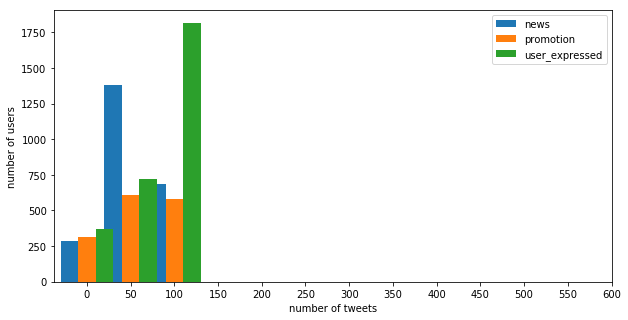

In [57]:
## ploting the news tweets distribution
plt.figure(figsize=(10,5))
news_t = get_tweet_distr(tweets_type,"news")
prom_t = get_tweet_distr(tweets_type, "prom")
euser_t = get_tweet_distr(tweets_type, "user_express") 
# ax = plt.subplot(111)
plt.bar(np.arange(0,len(news_t.keys())*50,50) - 20, news_t.values(), width = 20, label = "news",align='center')
plt.bar(np.arange(0,len(news_t.keys())*50,50), prom_t.values() , width = 20, label= "promotion", align='center')
plt.bar(np.arange(0,len(news_t.keys())*50,50) + 20, euser_t.values(), width = 20, label = "user_expressed", align='center')
plt.xticks(np.arange(0,650,50))
plt.ylabel("number of users")
plt.xlabel("number of tweets")
plt.legend()
plt.show()

In [58]:
## predicting users based on the category of
category = list()
for idx,tweet in tweets_type.iterrows():
    cat = np.argmax(list([tweet["news"],tweet["prom"],tweet["user_express"]]))
    category.append(cat)

In [59]:
tweets_type["category"] = category

In [71]:
## dump labelled tweets and tweets type
# file_name = os.path.join(input_dir,"labelled_data","tweets_predicted.csv")
# df_tweets.to_csv(file_name,index=False)
# file_name = os.path.join(input_dir,"labelled_data","users_type.csv")
# tweets_type.to_csv(file_name,index=False)

### getting the normal users

In [72]:
## getting all the tweets from normal users(who have max number of user expressed tweets)
regular_users = list(tweets_type["userID"].loc[tweets_type.category == 2])
normal_tweets = (df_tweets.loc[df_tweets.userID.isin(normal_users)])

In [73]:
len(regular_users)

2240

In [74]:
len(normal_tweets)

20426

## predicting poly and mono users.. (check with most common words as well)

## get poly and mono users

In [97]:
def build_vocab(tokens_list):
    vocab = Counter()
    for tokens in tokens_list:
        vocab.update(tokens)
    return vocab

In [98]:
# return clean text
def prepare_text_LDA(sentence):
#     tokens = nltk.word_tokenize(sentence)  # now using tweet tokenizer
    tweet_tknzr = TweetTokenizer()
    tokens = tweet_tknzr.tokenize(sentence)
    tokens = [token.lower() for token in tokens if (token not in stopwords and token.isalpha())] # stopwords removal
    tokens = [get_lemma(token) for token in tokens]  # lemmatization
    return (" ".join(tokens))

In [105]:
## join al the of the tweets for each user
def get_tweets_user(df):
    df_tweets_comb = list()
    users = df.userID.unique()
    for user in users:
        tweets =(df.loc[df.userID == user])
        tweets_f = (" . ".join(tweets["tweetText"]))
        df_tweets_comb.append((user,tweets_f))
    df_user = pd.DataFrame(df_tweets_comb, columns=["userID","tweetText"])
    return (df_user)

In [87]:
## getting the weed and juul pattern
print("extracting the pattern for weeds")
weed_words = pickle.load(open(os.path.join(model_dir, "weed_words.pkl"), "rb"))
weed_words.remove('CBD oil')
# weed_words = [(" " + word + " ") for word in weed_words]
pattern_weed = "|".join(weed_words)
print("extracting the pattern for juul")
pattern_juul = 'juul'

extracting the pattern for weeds
extracting the pattern for juul


In [88]:
pattern_weed

'weed|ganja|marijuana|grass|cannabis|pot|smoke|mary jane|hemp|marihuana|hash|reefer|hashish|herb|bhang|green goddess|locoweed|maryjane|bud|spliff|wacky baccy|joint|sinsemilla|doobie|acapulco gold|CBD|THC'

In [91]:
## preprocesing the tweets
normal_tweets["tweetText"] = normal_tweets["tweetText"].apply(clean_text)
normal_tweets["tweetText"] = (normal_tweets["tweetText"].apply(prepare_text_LDA))

In [92]:
## load the weed tweets
weed_tweets = normal_tweets[normal_tweets['tweetText'].str.contains(pattern_weed, case=False)]
print("weed tweets = ",len(weed_tweets))
poly_users = list(weed_tweets.userID.unique())
print("no of poly users = ", len(poly_users))

weed tweets =  13410
no of poly users =  666


In [93]:
normal_users = list(normal_tweets.userID.unique())
poly_length = len(poly_users)
total_users_length = len(normal_users)
mono_length = total_users_length - poly_length
print("total users = ", total_users_length)
print("no of poly users = ", poly_length)
print("no of mono users = ", mono_length)
print("% of poly users is ", poly_length / total_users_length)
print("% of mono users is ", mono_length / total_users_length)

total users =  2240
no of poly users =  666
no of mono users =  1574
% of poly users is  0.29732142857142857
% of mono users is  0.7026785714285714


## dump the users

In [96]:
# dump the poly_users,regualar_users
# poly_dir = os.path.join(model_dir,"poly_users")
# pathname = os.path.join(poly_dir,"poly_users.pkl")
# dump_obj(poly_users,pathname)
# pathname = os.path.join(poly_dir,"normal_users.pkl")
# dump_obj(regular_users,pathname)

In [94]:
import pickle
def dump_obj(obj,pathname):
    with open(pathname,"wb") as f:
        pickle.dump(obj,f)

### get the most common words

### load the poly - mono users

In [192]:
poly_users = pickle.load(open(os.path.join(poly_dir,"poly_users.pkl"),"rb"))
normal_users = pickle.load(open(os.path.join(poly_dir,"normal_users.pkl"),"rb"))
df_tweets = pd.read_csv(os.path.join(input_dir,"labelled_data","tweets_predicted.csv"),lineterminator="\n")

In [100]:
normal_tweets = df_tweets.loc[df_tweets.userID.isin(normal_users)]
poly_tweets = df_tweets.loc[df_tweets.userID.isin(poly_users)]
mono_users = list(set(normal_users) - set(poly_users))
mono_tweets = df_tweets.loc[df_tweets.userID.isin(mono_users)]

### with rt

In [101]:
print("all tweets by poly users: ", len(poly_tweets))
print("poly users (based with retweets):", len(poly_tweets.userID.unique()))

all tweets by poly users:  16585
poly users (based with retweets): 666


In [102]:
print("all tweets by mono users: ", len(mono_tweets))
print("mono users (based with retweets):", len(mono_tweets.userID.unique()))

all tweets by mono users:  3841
mono users (based with retweets): 1574


In [103]:
## cleaning the text
poly_tweets["tweetText"] = poly_tweets["tweetText"].apply(clean_text)
mono_tweets["tweetText"] = mono_tweets["tweetText"].apply(clean_text)
## tokenizing and lemmatizing
poly_tweets["tweetText"] = (poly_tweets["tweetText"].apply(prepare_text_LDA))
mono_tweets["tweetText"] = mono_tweets["tweetText"].apply(prepare_text_LDA)

### getting most coomon words for each user

In [106]:
poly_tweets_user = get_tweets_user(poly_tweets)
mono_tweets_user = get_tweets_user(mono_tweets)

In [107]:
tokens_p = list(poly_tweets_user["tweetText"].apply(get_tokens))
tokens_j = list(mono_tweets_user["tweetText"].apply(get_tokens))

In [108]:
vocab = build_vocab(tokens_p)
vocab.most_common()[:30]

[('cannabis', 7806),
 ('weed', 5855),
 ('marijuana', 5316),
 ('stone', 3748),
 ('stoner', 1820),
 ('smoke', 1817),
 ('juul', 1681),
 ('stonerfam', 1519),
 ('high', 1501),
 ('vape', 1447),
 ('bong', 1070),
 ('dope', 1033),
 ('stonercircle', 1014),
 ('staylifted', 1005),
 ('pipe', 970),
 ('find', 968),
 ('ganja', 953),
 ('get', 950),
 ('dank', 914),
 ('online', 847),
 ('code', 847),
 ('things', 846),
 ('relate', 824),
 ('coupon', 805),
 ('bud', 777),
 ('like', 770),
 ('maryjane', 740),
 ('cannabiscommunity', 735),
 ('follow', 716),
 ('kush', 686)]

In [110]:
## most common words for juul user tweets
vocab1 = build_vocab(tokens_j)
vocab1.most_common()[:30]

[('juul', 4010),
 ('like', 940),
 ('bitch', 812),
 ('hurt', 801),
 ('team', 799),
 ('tattoo', 799),
 ('tat', 797),
 ('yup', 795),
 ('worth', 795),
 ('captionthis', 795),
 ('pod', 319),
 ('happy', 268),
 ('get', 247),
 ('fortnite', 241),
 ('birthday', 222),
 ('one', 200),
 ('ruining', 168),
 ('friendship', 167),
 ('pt', 167),
 ('twitch', 156),
 ('vape', 155),
 ('love', 144),
 ('streaming', 137),
 ('xbox', 131),
 ('drilldobaggins', 130),
 ('console', 125),
 ('know', 115),
 ('battleroyale', 113),
 ('make', 112),
 ('kid', 111)]

## LDA

In [111]:
temp_dir = os.path.join(model_dir,"temp")

In [ ]:
dictionary = corpora.Dictionary(tokens_p)  # tokens_j
corpus = [dictionary.doc2bow(text) for text in tokens_p] # tokens_j
pickle.dump(corpus, open(os.path.join(temp_dir,'corpus_m.pkl'), 'wb'))
dictionary.save(os.path.join(temp_dir,'dictionary_m.gensim'))
## LDA
NUM_TOPICS = 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=8)
ldamodel.save(os.path.join(temp_dir,'model_m.gensim'))
topics = ldamodel.print_topics(num_words=4)

In [ ]:
for topic in topics:
    print(topic)

In [ ]:
## poly
dictionary = gensim.corpora.Dictionary.load(os.path.join(temp_dir,'dictionary_m.gensim'))
corpus = pickle.load(open(os.path.join(temp_dir,'corpus_m.pkl'), 'rb'))
lda = gensim.models.ldamodel.LdaModel.load(os.path.join(temp_dir,'model_m.gensim'))
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

In [ ]:
##### mono
dictionary = corpora.Dictionary(tokens_j)  # tokens_j
corpus = [dictionary.doc2bow(text) for text in tokens_j] # tokens_j
pickle.dump(corpus, open(os.path.join(temp_dir,'corpus_m.pkl'), 'wb'))
dictionary.save(os.path.join(temp_dir,'dictionary_m.gensim'))
## LDA
NUM_TOPICS = 5
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=8)
ldamodel.save(os.path.join(temp_dir,'model_m.gensim'))
topics = ldamodel.print_topics(num_words=4)

In [ ]:
## mono
dictionary = gensim.corpora.Dictionary.load(os.path.join(temp_dir,'dictionary_m.gensim'))
corpus = pickle.load(open(os.path.join(temp_dir,'corpus_m.pkl'), 'rb'))
lda = gensim.models.ldamodel.LdaModel.load(os.path.join(temp_dir,'model_m.gensim'))
lda_display = pyLDAvis.gensim.prepare(lda, corpus, dictionary, sort_topics=False)
pyLDAvis.display(lda_display)

## training_classifier to predict poly vs mono user -- no longer valid

## get further categorization of poly_subtypes

In [137]:
## @return the posotion of juul timeline in the list of weeds
def get_postion(times_j, list_w):
    if list_w is not None:
        pos = -1
        for idx,ele in enumerate(list_w):
            if (times_j) > ele:
                continue
            else:
                pos = idx
                break
        if pos == -1:
            pos = len(list_w)
        return pos

In [194]:
## combining hexagon_tweets with the hexagon_timeline tweets 
df_hexagon = pd.read_csv(os.path.join(input_dir,"hexagonData.csv"),lineterminator="\n")
df_sub = df_hexagon.loc[df_hexagon.userID.isin(df_tweets.userID.unique())]
df_final = pd.concat([df_tweets,df_sub])
len(df_final.userID.unique())

5520

In [196]:
print("*** starting with the poly sub type users")
juul_before = list()
juul_after = list()
# poly_middle = list()
_und = list()
total_users = list(df_final.userID.unique())
for user in tqdm(poly_users):
    user_tweets = df_final.loc[df_final.userID == user]
    user_tweets = user_tweets.sort_values(by='tweetCreatedAt', ascending=True)  # sort by tweet created at
    times_j = None
    list_w = None
    j_anchor = list(user_tweets['tweetCreatedAt'].loc[user_tweets['tweetText'].str.contains(pattern_juul, case=False)]) ## get the first occurance
    if j_anchor:
        time_j = pd.to_datetime(j_anchor[0])
    else:
        time_j = None
    weed_tweets = user_tweets[user_tweets['tweetText'].str.contains(pattern_weed, case=False)]
    if (len(weed_tweets) > 0):
        if (len(weed_tweets) > 0):
            list_w = pd.to_datetime(list(weed_tweets[
                                              'tweetCreatedAt']))
    else:
        list_w = None
    if (time_j is not None and list_w is not None):
        pos = get_postion(time_j,list_w)              ## @TODO change..create function
        if (pos == 0):
            juul_before.append(user)
        else:
            juul_after.append(user)
    else:
        _und.append(user)                         ## if we can't determine the juul tweets in the user..
print("Poly type users calculated")
print("total poly users =", len(poly_users))
print("****************\n")
print("% of juul before users = ", len(juul_before) / len(poly_users))
print("len of juul before = ",len(juul_before))
print("\n")
print("% of juul after users = ", len(juul_after) / len(poly_users))
print("len of juul after = ",len(juul_after))
print("\n")
print("len of undefined users = ", len(_und) )

  4%|▍         | 26/666 [00:00<00:02, 252.70it/s]

*** starting with the poly sub type users


100%|██████████| 666/666 [00:03<00:00, 203.81it/s]

Poly type users calculated
total poly users = 666
****************

% of juul before users =  0.33483483483483484
len of juul before =  223


% of juul after users =  0.6651651651651652
len of juul after =  443


len of undefined users =  0


Poly type users calculated
total users = 640

****************

% of juul before users =  0.190625
len of juul before =  122


% of juul after users =  0.809375
len of juul after =  518


% of undefined users =  0.0

## plotting the change of poly_before to poly again

In [197]:
## getting the poly_before user juul before and first weed tweet

In [198]:
len(juul_before)

223

In [209]:
juul_before_tweets = df_final.loc[df_final.userID.isin(juul_before)]

In [210]:
len(juul_before_tweets)

1485

In [211]:
juul_tweets = juul_before_tweets.loc[juul_before_tweets["tweetText"].str.contains(pattern_juul,case=False)]

In [212]:
## all the juul before users contain juul tweets
len(juul_tweets.userID.unique())

223

In [225]:
juul_tweets["tweetCreatedAt"] = pd.to_datetime(juul_tweets["tweetCreatedAt"])

In [226]:
poly_first_juul_weed = []
for user in juul_before:
    user_tweets = juul_tweets.loc[juul_tweets.userID == user]
    user_tweets = user_tweets.sort_values(by=["tweetCreatedAt"])
    if (list(user_tweets["tweetCreatedAt"])):
        anchor_juul = list(user_tweets["tweetCreatedAt"])[0]
        poly_first_juul_weed.append([user,anchor_juul])

In [227]:
poly_first_juul_weed = pd.DataFrame(poly_first_juul_weed,columns=["userID","juul_first"])

In [228]:
weed_tweets = juul_before_tweets.loc[juul_before_tweets["tweetText"].str.contains(pattern_weed,case=False)]

In [229]:
weed_first = []
for user in juul_before:
    user_tweets = weed_tweets.loc[weed_tweets.userID == user]
    user_tweets = user_tweets.sort_values(by=["tweetCreatedAt"])
    if (list(user_tweets["tweetCreatedAt"])):
        anchor_weed = list(user_tweets["tweetCreatedAt"])[0]
        anchor_weed = pd.to_datetime(anchor_weed)
        weed_first.append(anchor_weed)

In [230]:
poly_first_juul_weed["weed_first"] = weed_first

In [231]:
poly_first_juul_weed = poly_first_juul_weed.sort_values(by=["juul_first"],ascending=True)

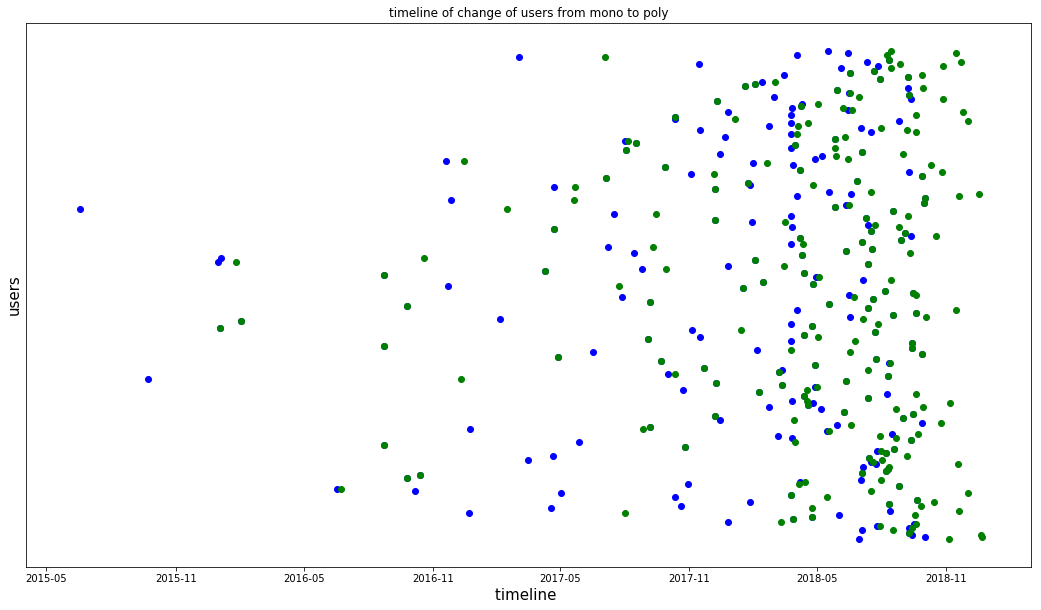

In [232]:
plt.figure(figsize=(18,10))
users_list = list(poly_first_juul_weed.userID.unique())
plt.scatter(list(poly_first_juul_weed["juul_first"]),[str(user) for user in users_list],color="blue")
plt.scatter(list(poly_first_juul_weed["weed_first"]), [str(user) for user in users_list],color="green")
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are of
plt.ylabel("users", fontsize = 15)
plt.xlabel("timeline ", fontsize=15)
plt.title("timeline of change of users from mono to poly" )

plt.show()

In [233]:
poly_first_juul_weed["interval"] = poly_first_juul_weed["weed_first"].dt.date - poly_first_juul_weed["juul_first"].dt.date

In [234]:
days = [ele.days() for ele in list(poly_first_juul_weed["interval"])]
days.sort()

TypeError: 'int' object is not callable

In [235]:
pos = 0
counts = {}
delta = 5000
counts[(pos+delta)] = 0
for ele in days:
    if  ele < pos + delta:
        counts[(pos+ delta)] += 1
    else:
        pos += delta
        counts[(pos + delta)] = 1

NameError: name 'days' is not defined

In [932]:
values = [ele[1] for ele in sorted(counts.items(), key=lambda x: x[0])]
keys = [ele[0] for ele in sorted(counts.items(), key=lambda x: x[0])]

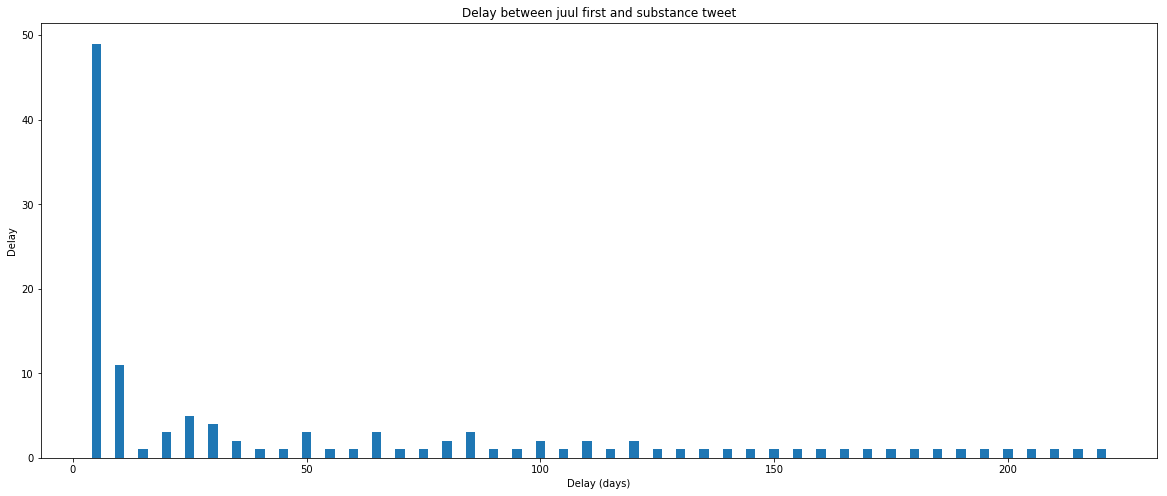

In [961]:
plt.figure(figsize=(20,8))
plt.bar(keys,values,width = 2)
plt.title("Delay between juul first and substance tweet")
plt.xlabel("Delay (days)")
plt.ylabel("Delay")
plt.show()

## gettng the network properties

In [236]:
df_following_final = pd.read_csv(os.path.join(input_dir,"following_final.csv"))

In [237]:
print(len(normal_users))
print(len(poly_users))
print(len(mono_users))

2240
666
1574


In [238]:
## selecting a subset of the following that contain the total users
df_poly_users = df_following_final[df_following_final.userID.isin(poly_users)]
df_mono_users = df_following_final[df_following_final.userID.isin(mono_users)]
df_all_users = df_following_final[df_following_final.userID.isin(total_users)]

In [239]:
def get_graph(df):
    G = nx.DiGraph()
    users = list(df.userID.unique())
    for user in tqdm(users):
        following_A = set(ast.literal_eval((df.loc[df.userID == user].head(1)["following"].values)[0]))
        user_set = set([node for node in users if node != user])
        users_list = user_set.intersection(following_A)
        for user_following in list(users_list):
            G.add_edge(user,user_following)
    return G

In [240]:
G_poly = get_graph(df_poly_users)
G_mono = get_graph(df_mono_users)
G_all = get_graph(df_all_users)

100%|██████████| 5490/5490 [00:24<00:00, 223.16it/s]


In [241]:
# color map 
def get_color_map(G,poly_users):
    color_map = list()
    for node in G.nodes():
        if int(node) in set(poly_users):
            color_map.append('green')
        else:
            color_map.append('blue')
    return color_map

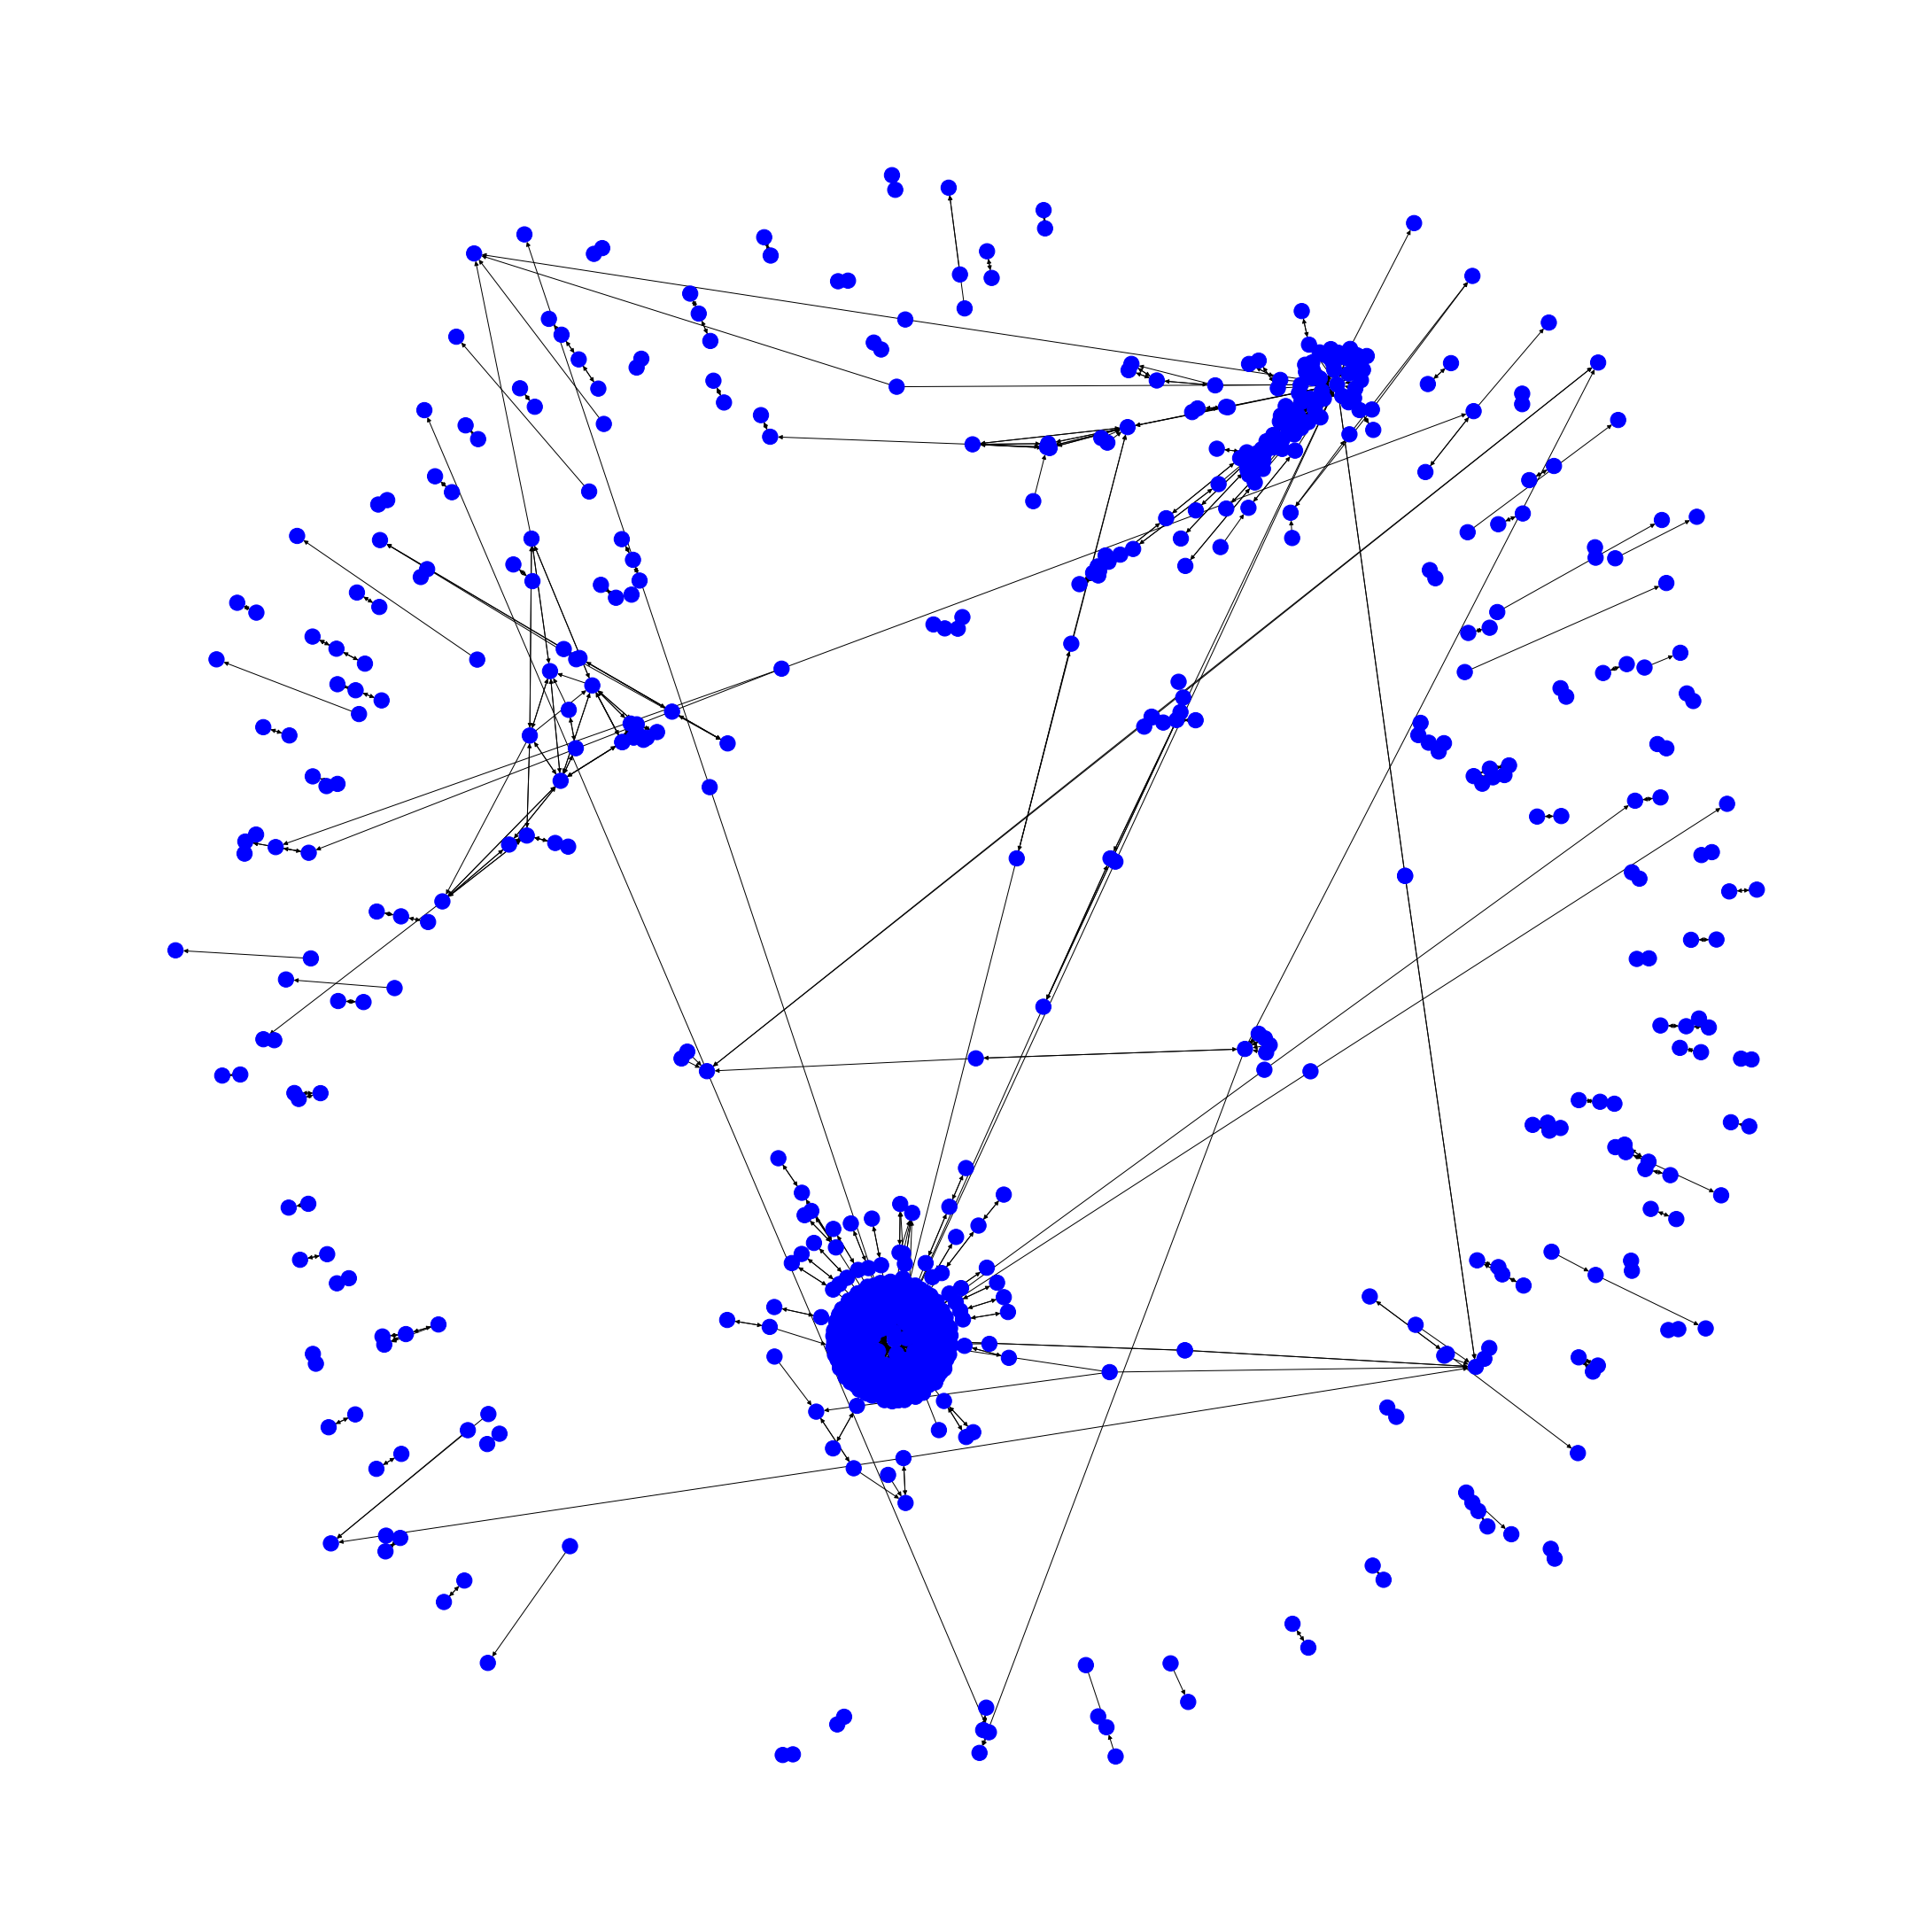

In [242]:
## mono viz --(filetersd)
color_map = get_color_map(G_mono,poly_users)
plt.figure(figsize=(30,30))
nx.draw(G_mono,node_color=color_map)

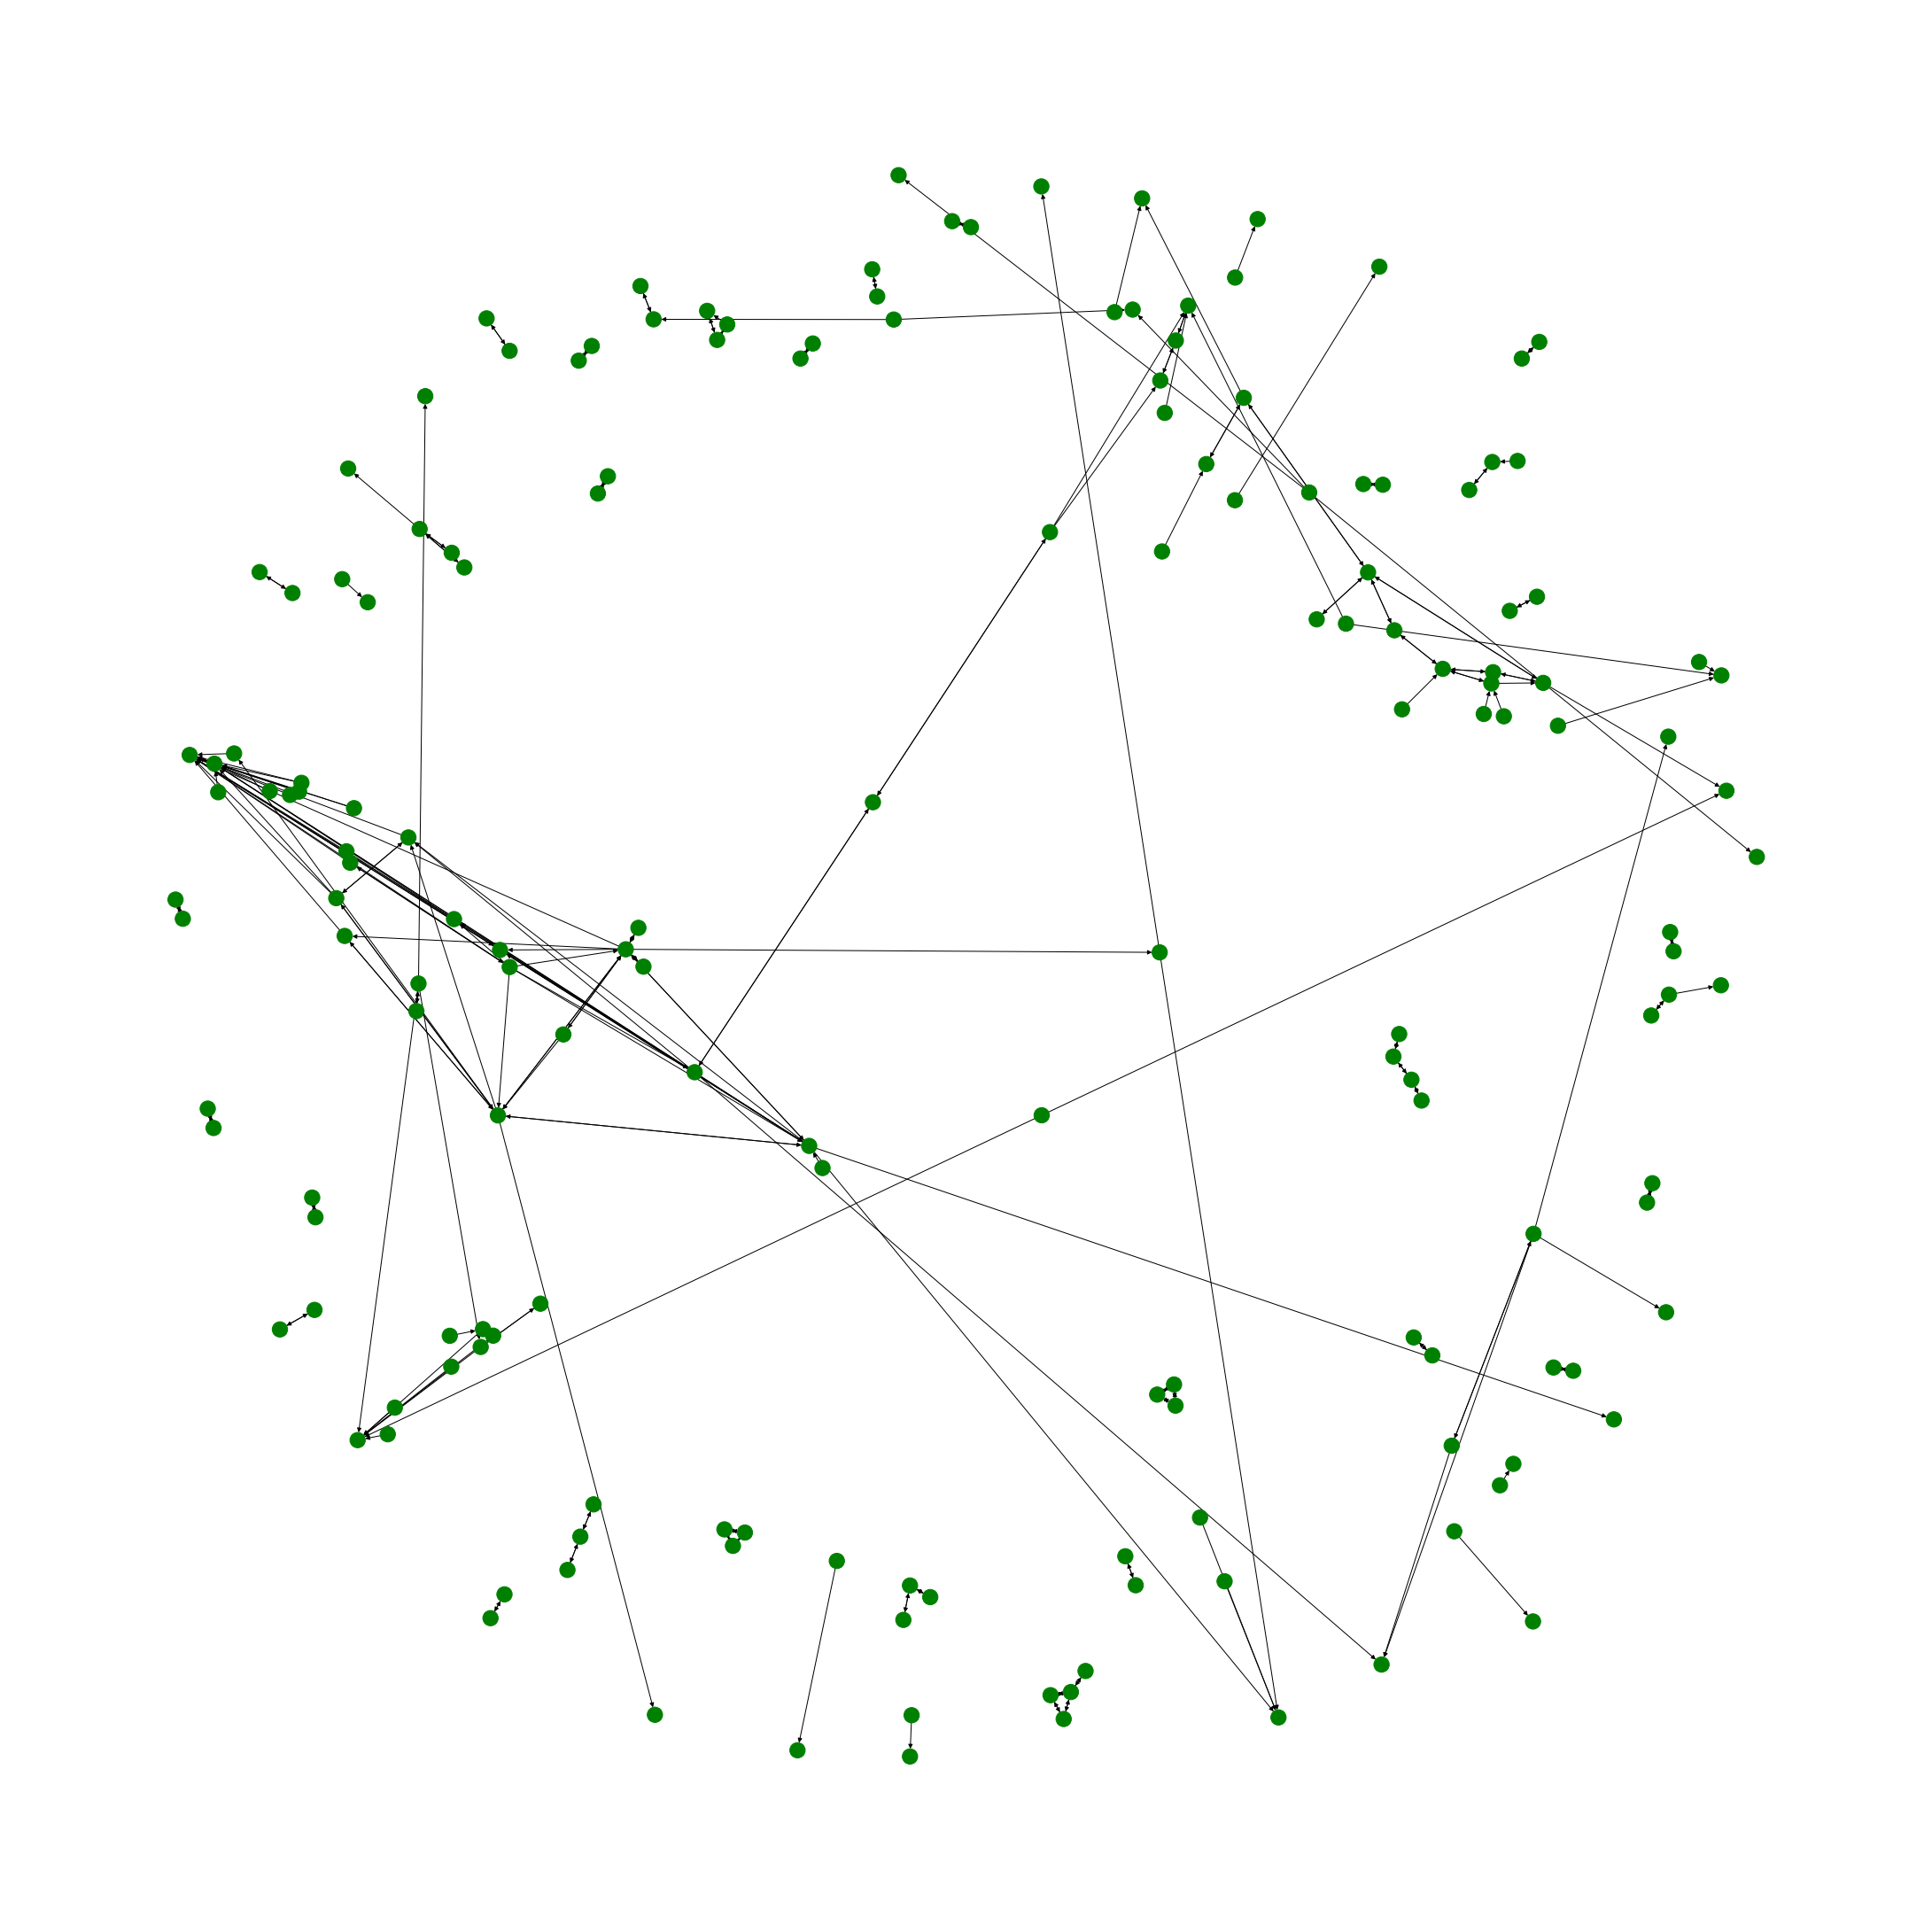

In [243]:
color_map = get_color_map(G_poly,poly_users)
plt.figure(figsize=(30,30))
nx.draw(G_poly,node_color=color_map)

In [ ]:
plt.figure(figsize=(50,50))
color_map = get_color_map(G_all,poly_users)
pos = nx.spring_layout(G_all)
nx.draw_networkx(G_all, pos=pos, node_color = color_map,with_label = False,arrows=True,labels=None)
plt.show()

In [245]:
print(nx.info(G_all))
print("average clustering poly",nx.average_clustering(G_all))

Name: 
Type: DiGraph
Number of nodes: 4123
Number of edges: 48038
Average in degree:  11.6512
Average out degree:  11.6512
average clustering poly 0.20148501031159116


In [246]:
print(nx.info(G_mono))
print("average clustering poly",nx.average_clustering(G_mono))

Name: 
Type: DiGraph
Number of nodes: 725
Number of edges: 1044
Average in degree:   1.4400
Average out degree:   1.4400
average clustering poly 0.10303839625816769


In [247]:
print(nx.info(G_poly))
print("average clustering mono",nx.average_clustering(G_poly))

Name: 
Type: DiGraph
Number of nodes: 170
Number of edges: 242
Average in degree:   1.4235
Average out degree:   1.4235
average clustering mono 0.12345329082427403


### get the change of mono as(poly_before) to poly

In [262]:
import datetime
date_format = "%Y-%m-%d"
time_format = "%Y-%m-%dT%H:%M:%S"
my_date = datetime.datetime.strptime("2015-01-03",date_format)
final_date = datetime.datetime.combine(my_date,datetime.time(10,0))

In [263]:
final_date.strftime(time_format)

'2015-01-03T10:00:00'

In [248]:
## bucket the users in bucket :
#1 2014 - [2015-2018] 
#2 2014- 2015 - [16 - 18]
#3 2014 - 2016 - [17-18]

In [252]:
len(df_hexagon)

12516

In [35]:
len(df_tweets.userID.unique())

4857

In [36]:
tweets_all = df_tweets.loc[df_tweets.userID.isin(normal_users)]

In [37]:
len(tweets_all)

42458

In [38]:
len(tweets_all.userID.unique())

2518

In [39]:
## first bucket 
tweets_all["tweetCreatedAt"] = pd.to_datetime(tweets_all.tweetCreatedAt)

In [40]:
tweets_2014 = tweets_all[tweets_all.tweetCreatedAt.dt.year < 2015]

In [41]:
len(tweets_2014)

1001

In [42]:
len(tweets_2014.userID.unique())

209

In [48]:
## combining all of the tweets of the user
tweets_2014 = get_tweets_user(tweets_2014)

In [316]:
label = []
for idx,row in tweets_2014.iterrows():
    if row['userID'] in poly_users:
        label.append("poly")
    else:
        label.append("mono")

In [317]:
tweets_2014["label"] = label

In [338]:
le = LabelEncoder()
le.fit(label)
print(le.classes_)
Y_true = le.transform(label)

['mono' 'poly']


In [321]:
## clean the tweets
tweets_2014["tweetText"] = tweets_2014["tweetText"].apply(clean_text)
tweets_2014["tweetText"] = tweets_2014["tweetText"].apply(prepare_text_LDA)

In [425]:
## load the model and tokenizer
lstm_model = pickle.load(open(os.path.join(poly_dir,"pomo_classifier_lstm.pkl"),"rb"))
keras_tkzr = pickle.load(open(os.path.join(poly_dir,"keras_tkzr.pkl"),"rb"))
le = pickle.load(open(os.path.join(poly_dir,"label_encoder.pkl"),"rb"))

In [428]:
max_len = 228
encoded_docs = keras_tkzr.texts_to_sequences(tweets_2014["tweetText"])
X_new = pad_sequences(encoded_docs, maxlen=max_len, padding='post')

In [429]:
Y_pred = [np.argmax(ele) for ele in lstm_model.predict(X_new,verbose=1)]

209/209 [==============================] - 1s 6ms/step


In [430]:
(Y_true == Y_pred).mean()

0.9090909090909091

In [431]:
print('  Classification Report:\n',classification_report(Y_true,Y_pred),'\n')

  Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.77      0.71        30
           1       0.96      0.93      0.95       179

   micro avg       0.91      0.91      0.91       209
   macro avg       0.81      0.85      0.83       209
weighted avg       0.92      0.91      0.91       209
 



### taking only mono users

In [432]:
## use the keywords to gather all of the mono users out of the poly ones

In [441]:
print("extracting the pattern for weeds")
weed_words = pickle.load(open(os.path.join(model_dir, "weed_words.pkl"), "rb"))
pattern_weed = "|".join(weed_words)

extracting the pattern for weeds


In [442]:
pattern_weed

'marijuana|grass|cannabis|mary jane|hemp|marihuana|hash|reefer|hashish|herb|bhang|green goddess|locoweed|maryjane|spliff|wacky baccy|joint|sinsemilla|doobie|tobacco|acapulco gold|weed|ganja'

In [443]:
weed_tweets = tweets_2014[tweets_2014["tweetText"].str.contains(pattern_weed)]

In [444]:
len(tweets_2014)

209

In [445]:
len(weed_tweets)

159

In [450]:
total_users = tweets_2014.userID.unique()

In [448]:
poly_user_a = weed_tweets.userID.unique()

In [449]:
len(poly_user_a)

159

In [451]:
mono_users_a = list(set(total_users)  - set(set(poly_user_a))) 

In [452]:
len(mono_users_a)

50

In [453]:
mono_tweets_2014 = tweets_2014.loc[tweets_2014.userID.isin(mono_users_a)]

In [459]:
len(mono_tweets_2014)

50

In [461]:
label = []
for idx,row in mono_tweets_2014.iterrows():
    if row['userID'] in poly_users:
        label.append("poly")
    else:
        label.append("mono")

In [462]:
len(label)

50

In [456]:
## load the model and tokenizer
pomo_lstm = pickle.load(open(os.path.join(poly_dir,"pomo_classifier_lstm.pkl"),"rb"))
keras_tkzr = pickle.load(open(os.path.join(poly_dir,"keras_tkzr.pkl"),"rb"))
le = pickle.load(open(os.path.join(poly_dir,"label_encoder.pkl"),"rb"))

In [465]:
le.fit(label)
print(le.classes_)
Y_true = le.transform(label)

['mono' 'poly']


In [458]:
## clean the tweets
mono_tweets_2014["tweetText"] = mono_tweets_2014["tweetText"].apply(clean_text)
mono_tweets_2014["tweetText"] = mono_tweets_2014["tweetText"].apply(prepare_text_LDA)

In [467]:
len([ele for ele in Y_true if ele == 1])

20

In [468]:
max_len = 228
encoded_docs = keras_tkzr.texts_to_sequences(mono_tweets_2014["tweetText"])
X_new = pad_sequences(encoded_docs, maxlen=max_len, padding='post')

In [469]:
X_new.shape

(50, 228)

In [470]:
Y_pred = [np.argmax(ele) for ele in pomo_lstm.predict(X_new,verbose=1)]

50/50 [==============================] - 1s 27ms/step


In [471]:
print('  Classification Report:\n',classification_report(Y_true,Y_pred),'\n')

  Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.77      0.77        30
           1       0.65      0.65      0.65        20

   micro avg       0.72      0.72      0.72        50
   macro avg       0.71      0.71      0.71        50
weighted avg       0.72      0.72      0.72        50
 



labels: 
mono 0
poly 1

## second_bucket

In [531]:
tweets_2015 = tweets_all[tweets_all.tweetCreatedAt.dt.year < 2016]

In [532]:
len(tweets_2015)

4181

In [500]:
total_users = (tweets_2015.userID.unique())
len(total_users)

333

In [506]:
## combining all of the tweets of the user
tweets_2015 = get_tweets_user(tweets_2015)

In [507]:
weed_tweets = tweets_2015[tweets_2015["tweetText"].str.contains(pattern_weed)]
len(weed_tweets)

205

In [508]:
poly_user_a = (weed_tweets.userID.unique())
len(poly_user_a)

205

In [509]:
mono_users_a = list(set(total_users)  - set(set(poly_user_a))) 
len(mono_users_a)

128

In [512]:
mono_tweets_2015 = tweets_2015[tweets_2015.userID.isin(mono_users_a)]

In [514]:
def get_labels(df,poly_users):
    label = []
    for idx,row in df.iterrows():
        if row['userID'] in poly_users:
            label.append("poly")
        else:
            label.append("mono")
    return label

In [515]:
labels = get_labels(mono_tweets_2015,poly_users)
len(labels)

In [489]:
## load the model and tokenizer
pomo_lstm = pickle.load(open(os.path.join(poly_dir,"pomo_classifier_lstm.pkl"),"rb"))
keras_tkzr = pickle.load(open(os.path.join(poly_dir,"keras_tkzr.pkl"),"rb"))
le = pickle.load(open(os.path.join(poly_dir,"label_encoder.pkl"),"rb"))

In [517]:
le.fit(label)
print(le.classes_)
Y_true = le.transform(labels)

['mono' 'poly']


In [518]:
## clean the tweets
mono_tweets_2015["tweetText"] = mono_tweets_2015["tweetText"].apply(clean_text)
mono_tweets_2015["tweetText"] = mono_tweets_2015["tweetText"].apply(prepare_text_LDA)

In [519]:
print("mono",len([ele for ele in Y_true if ele == 0]))
print("poly",len([ele for ele in Y_true if ele == 1]))

mono 72
poly 56


In [520]:
max_len = 228
encoded_docs = keras_tkzr.texts_to_sequences(mono_tweets_2015["tweetText"])
X_new = pad_sequences(encoded_docs, maxlen=max_len, padding='post')

In [521]:
X_new.shape

(128, 228)

In [522]:
Y_pred = [np.argmax(ele) for ele in pomo_lstm.predict(X_new,verbose=1)]

128/128 [==============================] - 2s 14ms/step


In [523]:
print('  Classification Report:\n',classification_report(Y_true,Y_pred),'\n')

  Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.83      0.86        72
           1       0.80      0.86      0.83        56

   micro avg       0.84      0.84      0.84       128
   macro avg       0.84      0.85      0.84       128
weighted avg       0.85      0.84      0.84       128
 



## bucket3

In [533]:
tweets_2016 = tweets_all[tweets_all.tweetCreatedAt.dt.year < 2017]

In [534]:
len(tweets_2016)

11772

In [535]:
total_users = (tweets_2016.userID.unique())
len(total_users)

508

In [538]:
## combining all of the tweets of the user
tweets_2016 = get_tweets_user(tweets_2016)

In [539]:
weed_tweets = tweets_2016[tweets_2016["tweetText"].str.contains(pattern_weed)]
len(weed_tweets)

294

In [540]:
poly_user_a = (weed_tweets.userID.unique())
len(poly_user_a)

294

In [541]:
mono_users_a = list(set(total_users)  - set(set(poly_user_a))) 
len(mono_users_a)

214

In [543]:
mono_tweets_2016 = tweets_2016[tweets_2016.userID.isin(mono_users_a)]

In [546]:
labels = get_labels(mono_tweets_2016,poly_users)
len(labels)

214

In [547]:
le.fit(label)
print(le.classes_)
Y_true = le.transform(labels)

['mono' 'poly']


In [548]:
## clean the tweets
mono_tweets_2016["tweetText"] = mono_tweets_2016["tweetText"].apply(clean_text)
mono_tweets_2016["tweetText"] = mono_tweets_2016["tweetText"].apply(prepare_text_LDA)

In [549]:
print("mono",len([ele for ele in Y_true if ele == 0]))
print("poly",len([ele for ele in Y_true if ele == 1]))

mono 147
poly 67


In [550]:
max_len = 228
encoded_docs = keras_tkzr.texts_to_sequences(mono_tweets_2016["tweetText"])
X_new = pad_sequences(encoded_docs, maxlen=max_len, padding='post')

In [551]:
X_new.shape

(214, 228)

In [552]:
Y_pred = [np.argmax(ele) for ele in pomo_lstm.predict(X_new,verbose=1)]

214/214 [==============================] - 0s 2ms/step


In [553]:
print('  Classification Report:\n',classification_report(Y_true,Y_pred),'\n')

  Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.89      0.90       147
           1       0.77      0.79      0.78        67

   micro avg       0.86      0.86      0.86       214
   macro avg       0.84      0.84      0.84       214
weighted avg       0.86      0.86      0.86       214
 



## bucket 4

In [557]:
tweets_2017 = tweets_all[tweets_all.tweetCreatedAt.dt.year < 2018]

In [559]:
len(tweets_2017)

18711

In [560]:
total_users = (tweets_2017.userID.unique())
len(total_users)

915

In [562]:
## combining all of the tweets of the user
tweets_2017 = get_tweets_user(tweets_2017)

In [563]:
weed_tweets = tweets_2017[tweets_2017["tweetText"].str.contains(pattern_weed)]
len(weed_tweets)

397

In [564]:
poly_user_a = (weed_tweets.userID.unique())
len(poly_user_a)

397

In [565]:
mono_users_a = list(set(total_users)  - set(set(poly_user_a))) 
len(mono_users_a)

518

In [566]:
mono_tweets_2017 = tweets_2017[tweets_2017.userID.isin(mono_users_a)]

In [567]:
labels = get_labels(mono_tweets_2017,poly_users)
len(labels)

518

In [568]:
le.fit(label)
print(le.classes_)
Y_true = le.transform(labels)

['mono' 'poly']


In [569]:
## clean the tweets
mono_tweets_2017["tweetText"] = mono_tweets_2017["tweetText"].apply(clean_text)
mono_tweets_2017["tweetText"] = mono_tweets_2017["tweetText"].apply(prepare_text_LDA)

In [570]:
print("mono",len([ele for ele in Y_true if ele == 0]))
print("poly",len([ele for ele in Y_true if ele == 1]))

mono 439
poly 79


In [571]:
max_len = 228
encoded_docs = keras_tkzr.texts_to_sequences(mono_tweets_2017["tweetText"])
X_new = pad_sequences(encoded_docs, maxlen=max_len, padding='post')

In [572]:
X_new.shape

(518, 228)

In [573]:
Y_pred = [np.argmax(ele) for ele in pomo_lstm.predict(X_new,verbose=1)]

518/518 [==============================] - 1s 2ms/step


In [574]:
print('  Classification Report:\n',classification_report(Y_true,Y_pred),'\n')

  Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.95      0.96       439
           1       0.76      0.82      0.79        79

   micro avg       0.93      0.93      0.93       518
   macro avg       0.87      0.89      0.88       518
weighted avg       0.94      0.93      0.94       518
 



In [644]:
x_label

['2014', '2014-2015', '2014-2016', '2014-2017']

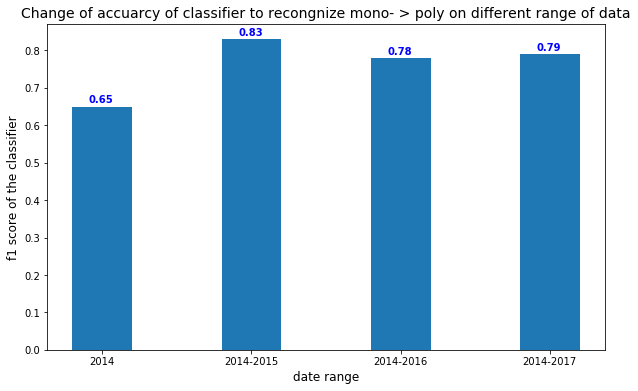

In [645]:
fig, ax = plt.subplots(figsize = (10,6))
ax.bar(x_label,f1_classifier,width=0.4)
plt.title("Change of accuarcy of classifier to recongnize mono- > poly on different range of data",fontsize=14)
plt.xlabel("date range",fontsize=12)
plt.ylabel("f1 score of the classifier",fontsize=12)
for i, v in enumerate(f1_classifier):
    plt.text(i - 0.09,v + 0.01, str(v), color='blue', fontweight='bold')
#-- need to change with f1 score acuarcy instead of just poly_accuarcy

# looking at the most predictive weights for the SVM classifier

In [157]:
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.preprocessing.text import Tokenizer as keras_Tokenizer
from sklearn.metrics import classification_report
keras_tkzr = keras_Tokenizer()

In [237]:
def clean_tweets(df):
    df["tweetText"] = df["tweetText"].apply(clean_text)
    df["tweetText"] = df["tweetText"].apply(prepare_text_LDA)
    return (df)

In [235]:
def get_label(df):
    # poly_users global
    label = []
    for idx,row in df.iterrows():
        if row['userID'] in poly_users:
            label.append("poly")
        else:
            label.append("mono")
    return label

In [344]:
def encode(label):
    le = LabelEncoder()
    le.fit(label)
    y = le.transform(label)
    return y

In [345]:
def get_data(df):
    label = get_label(df)
#     y = encode(label)
    tf_idf = TfidfVectorizer(sublinear_tf=True)
    tf_idf.fit(df["tweetText"])
    feature_names = np.array(tf_idf.get_feature_names())
    X = tf_idf.fit_transform(df["tweetText"])
    print(X.shape)
    return (X,np.array(label),tf_idf)

In [346]:
def svm_wrapper(X_train,Y_train):
    svm = LinearSVC(C=10)
    svm.fit(X_train,Y_train,)
    return svm

In [347]:
def plot_coeff(k,model,feature_names):
    coef = (model.coef_.ravel()) 
    top_positive_coefficients = np.argsort(coef)[-k:]
    top_negative_coefficients = np.argsort(coef)[:k]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(20, 8))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    plt.bar(np.arange(2 * k), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * k), feature_names[top_coefficients], rotation=60, ha='right',fontsize= 20)
    plt.show()
    return coef

In [348]:
len(df_tweets.userID.unique())

4857

In [349]:
tweets_all = df_tweets.loc[df_tweets.userID.isin(normal_users)]

In [350]:
print("total tweets ",len(tweets_all))
print("users", len(tweets_all.userID.unique()))

total tweets  42458
users 2518


In [ ]:
tweets_ = clean_tweets(tweets_all)
tweets_user = get_tweets_user(tweets_)  ## combining all of the tweets of the user
X,y,tf_idf_final = get_data(tweets_user)
X_train,X_test, Y_train, Y_test = train_test_split(X,y,test_size=0.25,random_state =4)
svm_final = svm_wrapper(X_train,Y_train)
## svm accuracy on poly mono data ## C=1 kernel= linear
Y_pred = svm_final.predict(X_test)
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')

In [452]:
np.mean(Y_test == Y_pred)

0.9555555555555556

In [353]:
## shape
print(X_train.shape)
print(Y_train.shape)

(1888, 29334)
(1888,)


In [354]:
## vocalb size
print(len(tf_idf.get_feature_names()))

29334


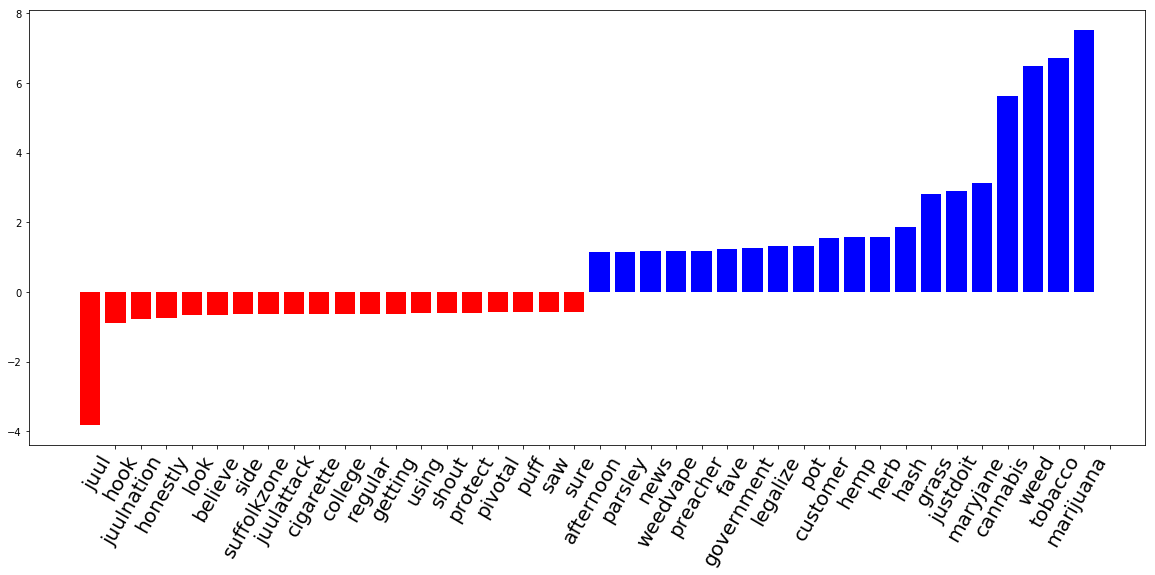

In [408]:
coeff = plot_coeff(20,svm_final,tf_idf_final.get_feature_names())

In [356]:
k = 20
coef = (svm.coef_.ravel()) 
feature_names = np.array(tf_idf.get_feature_names())
top_positive_coefficients = np.argsort(coef)[-k:]
list(feature_names[top_positive_coefficients][::-1])

['marijuana',
 'tobacco',
 'weed',
 'cannabis',
 'maryjane',
 'justdoit',
 'grass',
 'hash',
 'herb',
 'hemp',
 'customer',
 'pot',
 'legalize',
 'government',
 'fave',
 'preacher',
 'weedvape',
 'news',
 'parsley',
 'afternoon']

In [357]:
top_negative_coefficients = np.argsort(coef)[:k]
list(feature_names[top_negative_coefficients])

['juul',
 'hook',
 'juulnation',
 'honestly',
 'look',
 'believe',
 'side',
 'suffolkzone',
 'juulattack',
 'cigarette',
 'college',
 'regular',
 'getting',
 'using',
 'shout',
 'protect',
 'pivotal',
 'puff',
 'saw',
 'sure']

# Buckets - svm

## bucket 2014

In [422]:
tweets_all = df_tweets.loc[df_tweets.userID.isin(normal_users)]
f_scores = []
years = []

In [431]:
tweets_all["tweetCreatedAt"] = pd.to_datetime(tweets_all.tweetCreatedAt)

In [417]:
tweets = tweets_all[tweets_all.tweetCreatedAt.dt.year < 2015]

In [418]:
print("tweets",len(tweets))
print("users",len(tweets.userID.unique()))

tweets 1001
users 209


In [423]:
tweets_ = clean_tweets(tweets)
tweets_user = get_tweets_user(tweets_)  ## combining all of the tweets of the user
X,y,tf_idf = get_data(tweets_user)
X_train,X_test, Y_train, Y_test = train_test_split(X,y,test_size=0.25,random_state =4)
svm = svm_wrapper(X_train,Y_train)
## svm accuracy on poly mono data ## C=1 kernel= linear
Y_pred = svm.predict(X_test)
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')
_,_,fscore,_ = precision_recall_fscore_support(Y_test,Y_pred)
# print(np.average(fscore))
f_scores.append(np.average(fscore)) 

(209, 3034)
  Classification Report:
               precision    recall  f1-score   support

        mono       1.00      0.10      0.18        10
        poly       0.83      1.00      0.91        43

   micro avg       0.83      0.83      0.83        53
   macro avg       0.91      0.55      0.54        53
weighted avg       0.86      0.83      0.77        53
 



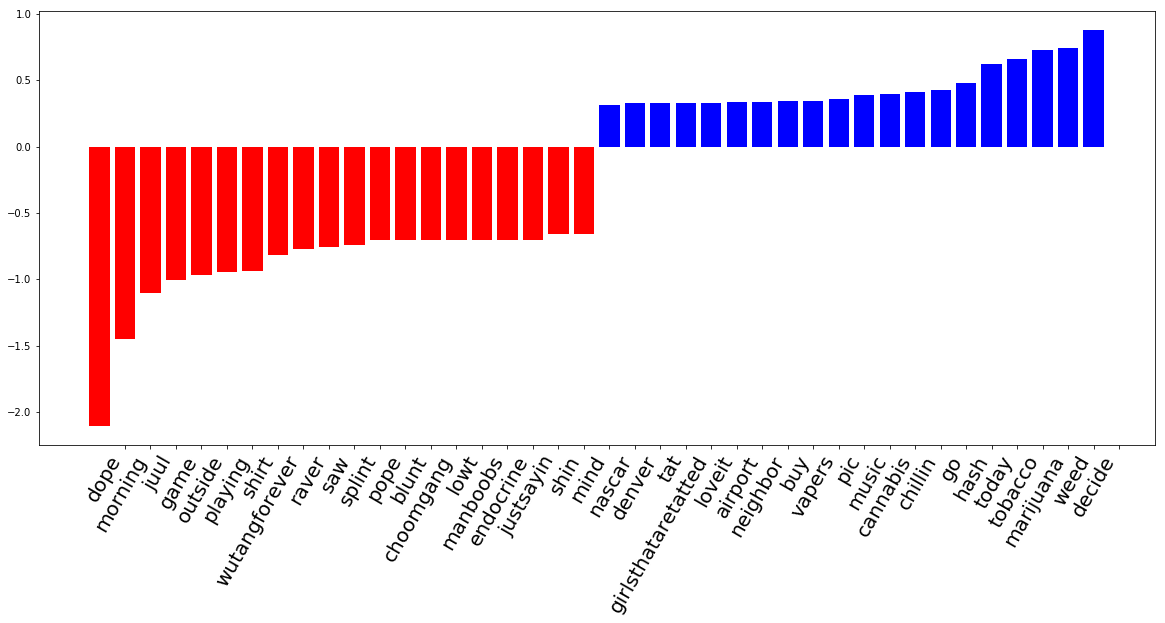

In [393]:
coeff = plot_coeff(20,svm,tf_idf.get_feature_names())

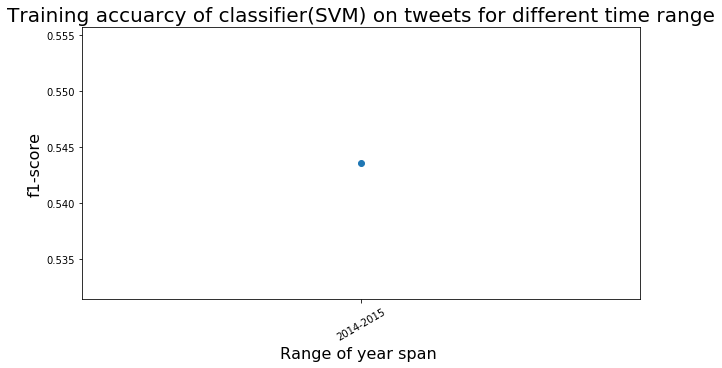

In [429]:
plt.figure(figsize=(10,5))
years = ["2014-2015"]
plt.scatter(years, f_scores)
plt.title("Training accuarcy of classifier(SVM) on tweets for different time range",fontsize = 20)
plt.xlabel("Range of year span ",fontsize = 16)
plt.ylabel("f1-score",fontsize = 16)
plt.xticks(rotation=30, ha='center')
plt.show()

## bucket 2015

In [432]:
tweets = tweets_all[tweets_all.tweetCreatedAt.dt.year < 2016]

In [433]:
print("tweets",len(tweets))
print("users",len(tweets.userID.unique()))

tweets 4181
users 333


In [434]:
tweets_ = clean_tweets(tweets)
tweets_user = get_tweets_user(tweets_)  ## combining all of the tweets of the user
X,y,tf_idf = get_data(tweets_user)
X_train,X_test, Y_train, Y_test = train_test_split(X,y,test_size=0.25,random_state =4)
svm = svm_wrapper(X_train,Y_train)
## svm accuracy on poly mono data ## C=1 kernel= linear
Y_pred = svm.predict(X_test)
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')
_,_,fscore,_ = precision_recall_fscore_support(Y_test,Y_pred)
# print(np.average(fscore))
f_scores.append(np.average(fscore)) 

(333, 7146)
  Classification Report:
               precision    recall  f1-score   support

        mono       0.73      0.53      0.62        15
        poly       0.90      0.96      0.93        69

   micro avg       0.88      0.88      0.88        84
   macro avg       0.82      0.74      0.77        84
weighted avg       0.87      0.88      0.87        84
 



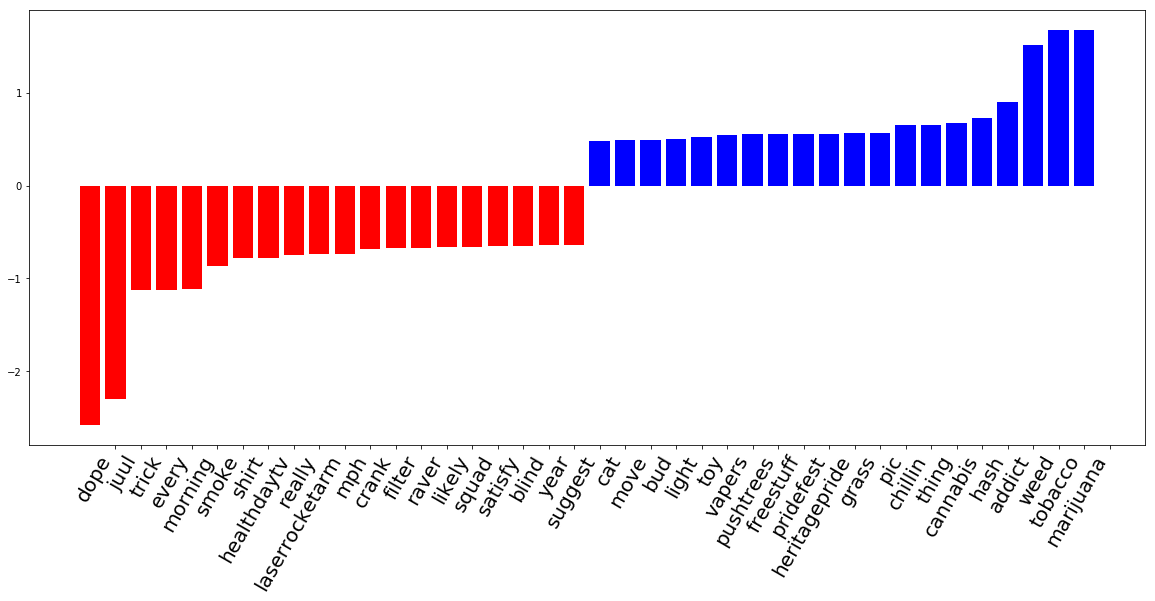

In [397]:
coeff = plot_coeff(20,svm,tf_idf.get_feature_names())

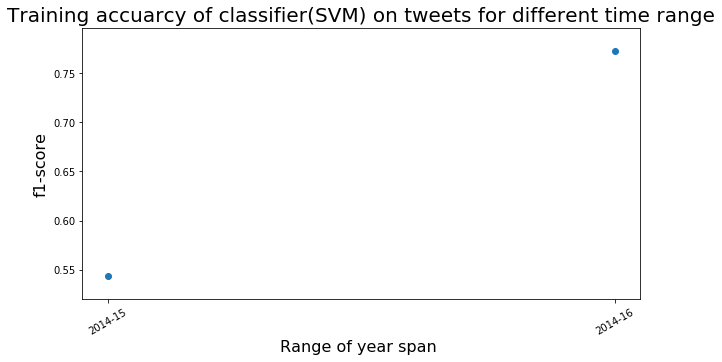

In [435]:
plt.figure(figsize=(10,5))
years = ["2014-15","2014-16"]
plt.scatter(years, f_scores)
plt.title("Training accuarcy of classifier(SVM) on tweets for different time range",fontsize = 20)
plt.xlabel("Range of year span ",fontsize = 16)
plt.ylabel("f1-score",fontsize = 16)
plt.xticks(rotation=30, ha='center')
plt.show()

# Bucket 2016

In [399]:
tweets = tweets_all[tweets_all.tweetCreatedAt.dt.year < 2017]

In [401]:
print("tweets",len(tweets))
print("users",len(tweets.userID.unique()))

tweets 11772
users 508


In [436]:
tweets_ = clean_tweets(tweets)
tweets_user = get_tweets_user(tweets_)  ## combining all of the tweets of the user
X,y,tf_idf = get_data(tweets_user)
X_train,X_test, Y_train, Y_test = train_test_split(X,y,test_size=0.25,random_state =4)
svm = svm_wrapper(X_train,Y_train)
## svm accuracy on poly mono data ## C=1 kernel= linear
Y_pred = svm.predict(X_test)
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')
_,_,fscore,_ = precision_recall_fscore_support(Y_test,Y_pred)
# print(np.average(fscore))
f_scores.append(np.average(fscore)) 

(333, 7052)
  Classification Report:
               precision    recall  f1-score   support

        mono       0.73      0.53      0.62        15
        poly       0.90      0.96      0.93        69

   micro avg       0.88      0.88      0.88        84
   macro avg       0.82      0.74      0.77        84
weighted avg       0.87      0.88      0.87        84
 



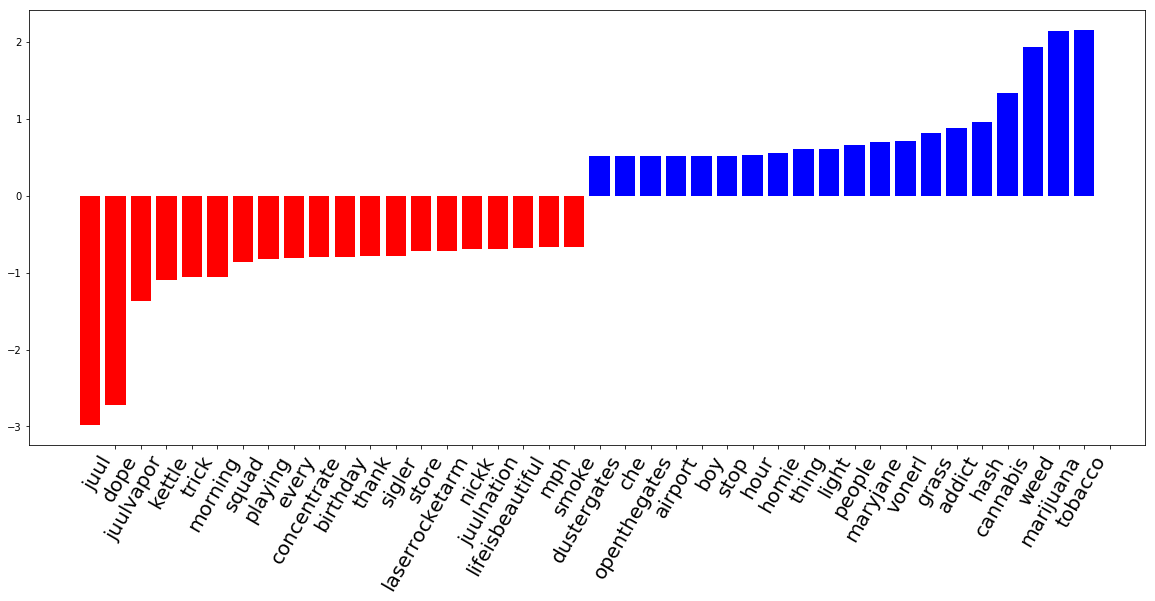

In [403]:
coeff = plot_coeff(20,svm,tf_idf.get_feature_names())

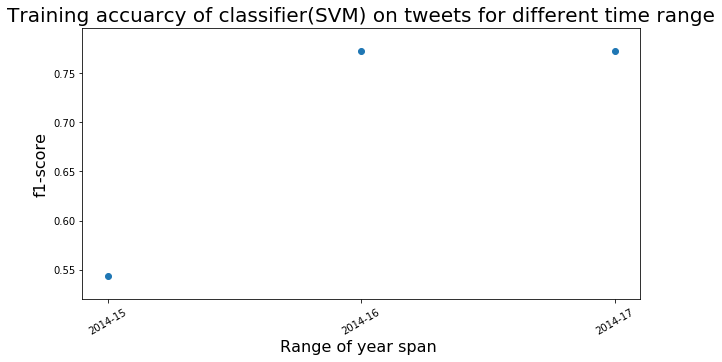

In [437]:
plt.figure(figsize=(10,5))
years = ["2014-15","2014-16","2014-17"]
plt.scatter(years, f_scores)
plt.title("Training accuarcy of classifier(SVM) on tweets for different time range",fontsize = 20)
plt.xlabel("Range of year span ",fontsize = 16)
plt.ylabel("f1-score",fontsize = 16)
plt.xticks(rotation=30, ha='center')
plt.show()

##  bucket 2017

In [438]:
year_c = 2018
tweets = tweets_all[tweets_all.tweetCreatedAt.dt.year < year_c]
print("tweets",len(tweets))
print("users",len(tweets.userID.unique()))
tweets_ = clean_tweets(tweets)
tweets_user = get_tweets_user(tweets_)  ## combining all of the tweets of the user
X,y,tf_idf = get_data(tweets_user)
X_train,X_test, Y_train, Y_test = train_test_split(X,y,test_size=0.25,random_state =4)
svm = svm_wrapper(X_train,Y_train)
## svm accuracy on poly mono data ## C=1 kernel= linear
Y_pred = svm.predict(X_test)
print('  Classification Report:\n',classification_report(Y_test,Y_pred),'\n')
_,_,fscore,_ = precision_recall_fscore_support(Y_test,Y_pred)
# print(np.average(fscore))
f_scores.append(np.average(fscore)) 

tweets 18711
users 915
(915, 16137)
  Classification Report:
               precision    recall  f1-score   support

        mono       0.87      0.93      0.90       109
        poly       0.93      0.88      0.90       120

   micro avg       0.90      0.90      0.90       229
   macro avg       0.90      0.90      0.90       229
weighted avg       0.90      0.90      0.90       229
 



tweets 18711
users 915
(915, 16137)
  Classification Report:
               precision    recall  f1-score   support

        mono       0.87      0.93      0.90       109
        poly       0.93      0.88      0.90       120

   micro avg       0.90      0.90      0.90       229
   macro avg       0.90      0.90      0.90       229
weighted avg       0.90      0.90      0.90       229
 



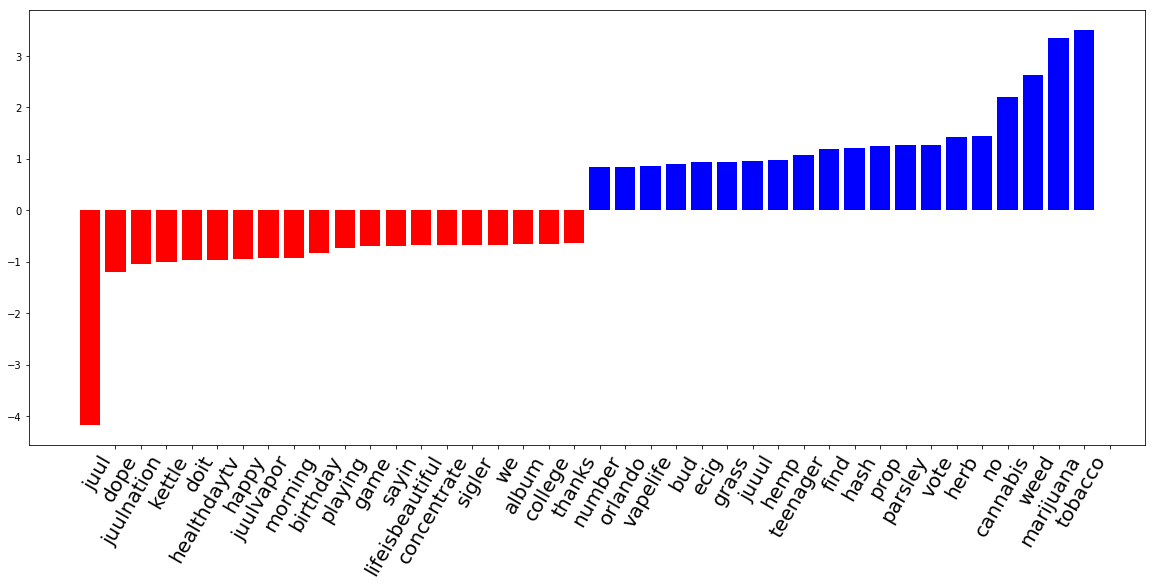

In [405]:
coeff = plot_coeff(20,svm,tf_idf.get_feature_names())

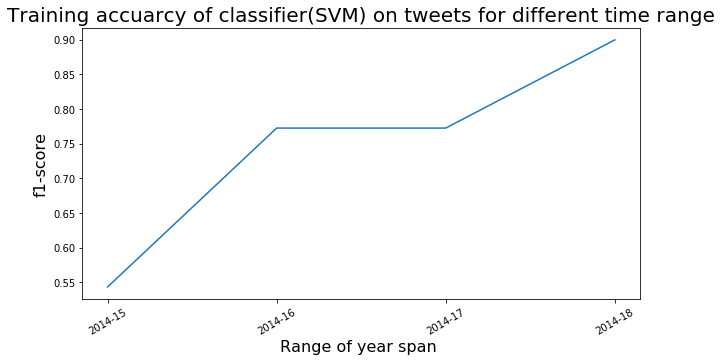

In [439]:
plt.figure(figsize=(10,5))
years = ["2014-15","2014-16","2014-17","2014-18"]
plt.plot(years, f_scores)
plt.title("Training accuarcy of classifier(SVM) on tweets for different time range",fontsize = 20)
plt.xlabel("Range of year span ",fontsize = 16)
plt.ylabel("f1-score",fontsize = 16)
plt.xticks(rotation=30, ha='center')
plt.show()

# change of accuracy of the svm model using only the specific year data

In [410]:
## prediction
tweets = tweets_all[tweets_all.tweetCreatedAt.dt.year < 2015]
tweets_ = clean_tweets(tweets)
tweets_user = get_tweets_user(tweets_)  ## combining all of the tweets of the user
X_test = tf_idf_final.transform(tweets_user["tweetText"])
Y_true = get_label(tweets_user)
y_pred = svm_final.predict(X_test)
print('  Classification Report:\n',classification_report(Y_true,y_pred),'\n')

  Classification Report:
               precision    recall  f1-score   support

        mono       0.63      0.97      0.76        30
        poly       0.99      0.91      0.95       179

   micro avg       0.91      0.91      0.91       209
   macro avg       0.81      0.94      0.86       209
weighted avg       0.94      0.91      0.92       209
 



In [411]:
year_c = 2016
tweets = tweets_all[tweets_all.tweetCreatedAt.dt.year < year_c]
tweets_ = clean_tweets(tweets)
tweets_user = get_tweets_user(tweets_)  ## combining all of the tweets of the user
X_test = tf_idf_final.transform(tweets_user["tweetText"])
Y_true = get_label(tweets_user)
y_pred = svm_final.predict(X_test)
print('  Classification Report:\n',classification_report(Y_true,y_pred),'\n')

  Classification Report:
               precision    recall  f1-score   support

        mono       0.77      0.99      0.87        72
        poly       1.00      0.92      0.96       261

   micro avg       0.93      0.93      0.93       333
   macro avg       0.88      0.95      0.91       333
weighted avg       0.95      0.93      0.94       333
 



In [412]:
year_c = 2017
tweets = tweets_all[tweets_all.tweetCreatedAt.dt.year < year_c]
tweets_ = clean_tweets(tweets)
tweets_user = get_tweets_user(tweets_)  ## combining all of the tweets of the user
X_test = tf_idf_final.transform(tweets_user["tweetText"])
Y_true = get_label(tweets_user)
y_pred = svm_final.predict(X_test)
print('  Classification Report:\n',classification_report(Y_true,y_pred),'\n')

  Classification Report:
               precision    recall  f1-score   support

        mono       0.87      0.99      0.92       147
        poly       0.99      0.94      0.97       361

   micro avg       0.95      0.95      0.95       508
   macro avg       0.93      0.96      0.94       508
weighted avg       0.96      0.95      0.95       508
 



In [413]:
year_c = 2018
tweets = tweets_all[tweets_all.tweetCreatedAt.dt.year < year_c]
tweets_ = clean_tweets(tweets)
tweets_user = get_tweets_user(tweets_)  ## combining all of the tweets of the user
X_test = tf_idf_final.transform(tweets_user["tweetText"])
Y_true = get_label(tweets_user)
y_pred = svm_final.predict(X_test)
print('  Classification Report:\n',classification_report(Y_true,y_pred),'\n')

  Classification Report:
               precision    recall  f1-score   support

        mono       0.95      1.00      0.97       439
        poly       1.00      0.95      0.97       476

   micro avg       0.97      0.97      0.97       915
   macro avg       0.97      0.97      0.97       915
weighted avg       0.97      0.97      0.97       915
 



In [414]:
year_c = 2019
tweets = tweets_all[tweets_all.tweetCreatedAt.dt.year < year_c]
tweets_ = clean_tweets(tweets)
tweets_user = get_tweets_user(tweets_)  ## combining all of the tweets of the user
X_test = tf_idf_final.transform(tweets_user["tweetText"])
Y_true = get_label(tweets_user)
y_pred = svm_final.predict(X_test)
print('  Classification Report:\n',classification_report(Y_true,y_pred),'\n')

  Classification Report:
               precision    recall  f1-score   support

        mono       0.99      1.00      0.99      1878
        poly       0.99      0.96      0.98       640

   micro avg       0.99      0.99      0.99      2518
   macro avg       0.99      0.98      0.98      2518
weighted avg       0.99      0.99      0.99      2518
 



## looking at the cascades

In [647]:
import operator
def get_depth(G):
    level = nx.get_node_attributes(G,'level')
    if not level:
        level = nx.get_node_attributes(G,'depth')
    depth = max(level.items(), key=operator.itemgetter(1))[1]
    return depth

In [652]:
graph_path = os.path.join(top_dir,"models","graphs2")

In [653]:
filenames = [file for file in os.listdir(os.path.join(os.getcwd(),graph_path)) if file.endswith(".gpickle")]

In [654]:
len(filenames)

194

In [762]:
def get_type_nodes(G,main_node,poly_users):
    poly_nodes = []
    mono_nodes = []
    for node in G:
        if node != main_node:
            if node in set(poly_users):
                poly_nodes.append(node)
            else:
                mono_nodes.append(node)
    return (poly_nodes,mono_nodes)

In [763]:
## checking the influence in the cascades..
## influence = no of poly/mono / total no of nodes
influence_poly = []
influence_mono = []
for file in filenames:
    G = nx.read_gpickle(os.path.join(graph_path,file))
    depth = nx.get_node_attributes(G,'level')
    main_node = [node for node,level in depth.items() if level ==0]
    poly_nodes,mono_nodes =  get_type_nodes(G,main_node,poly_users)
#     if len(G.nodes) > 30:
    if main_node[0] in set(poly_users):
        influence_poly.append(len(poly_nodes)/(len(poly_nodes)+len(mono_nodes)))
    else:
        influence_mono.append(len(mono_nodes)/(len(poly_nodes)+len(mono_nodes)))

In [768]:
len(influence_poly)

20

In [765]:
len(influence_mono)

174

In [766]:
np.mean(influence_mono) 

0.9032012359080813

In [767]:
np.mean(influence_poly)

0.21036162375636058

In [760]:
len(poly_users)

640